In [97]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import itertools
from collections import Counter
from networkx.drawing.nx_agraph import graphviz_layout
import statistics
import seaborn as sns
from os import walk
import math
from scipy import stats
from matplotlib import rcParams

## Import Partial Correlation Matrices

In [98]:
americanPartial = pd.read_csv("./DataFiles/GGM/american_partial.csv")
indianPartial = pd.read_csv("./DataFiles/GGM/indian_partial.csv")
europeanPartial = pd.read_csv("./DataFiles/GGM/european_partial.csv")
japanesePartial = pd.read_csv("./DataFiles/GGM/japanese_partial.csv")

## Import Relative Abundance Matrix

In [99]:
allSpecies = pd.read_csv("./DataFiles/Dataframes/allCohorts_allSpecies.csv").set_index("SampleName")
americanSpecies = allSpecies[allSpecies['Cohort']=='American'].copy()
indianSpecies = allSpecies[allSpecies['Cohort']=='Indian'].copy()
europeanSpecies = allSpecies[allSpecies['Cohort']=='European'].copy()
japaneseSpecies = allSpecies[allSpecies['Cohort']=='Japanese'].copy()
allSpecies.shape

(606, 2079)

In [100]:
BacterialPhylums = {"Unclassified_Bacteria":"Unknown", "Acidobacteria":'Gram_Negative',"Actinobacteria":'Gram_Positive',"Aquificae":'Gram_Negative',"Armatimonadetes":'Gram_Negative',"Bacteroidetes":'Gram_Negative',"Balneolaeota":'Unknown',"Caldiserica":"Unknown","Calditrichaeota":"Unknown","Chlamydiae":'Gram_Negative',"Chlorobi":"Unknown","Chloroflexi":"Unknown","Chrysiogenetes":"Unknown","Coprothermobacterota":"Unknown","Cyanobacteria":"Unknown","Deferribacteres":"Gram_Negative","Deinococcus-Thermus":"Gram_Negative","Dictyoglomi":"Gram_Negative","Elusimicrobia":"Unknown","Fibrobacteres":"Unknown","Firmicutes":"Gram_Positive","Fusobacteria":"Gram_Negative","Gemmatimonadetes":"Gram_Negative","Kiritimatiellaeota":"Unkown","Lentisphaerae":"Unknown","Nitrospirae":"Unknown","Planctomycetes":"Unknown","Proteobacteria":"Gram_Negative","Rhodothermaeota":"Unknown","Spirochaetes":"Gram_Negative","Synergistetes":"Gram_Negative","Tenericutes":"Unknown","Thermodesulfobacteria":"Unknown","Thermotogae":"Gram_Negative","Verrucomicrobia":"Unknown"}

In [101]:
accTaxDictDF = pd.read_csv("./DataFiles/Dataframes/Master_Rename.csv").set_index("Bacterial_Strain")
accTaxDictDF['Species'] = accTaxDictDF['Species'].astype(str)
accTaxDictDF2 = accTaxDictDF.reset_index().set_index("Species").copy()
accTaxDictDF3 = accTaxDictDF2.loc[~accTaxDictDF2.index.duplicated(keep='first')].copy()

In [102]:
generaFindDF = accTaxDictDF.reset_index().set_index("Species").copy()
generaFindDF_master = generaFindDF.loc[~generaFindDF.index.duplicated(keep='first')].copy()

## Pull Partial Correlations

In [103]:
#Takes in the partial correlation matrix pulls top triangle and returns associations that are not 0 or -1
def allAssociations(df):
    df2 = df.copy()
    df3 = df2.drop(columns=['Unnamed: 0']).copy()
    indexRename = {}
    count = 0
    
    for column in df3.columns:
        indexRename[count] = column
        count+=1
        
    df3.rename(index=indexRename, inplace=True)

    df4 = df3.where(np.triu(np.ones(df3.shape)).astype(np.bool))
    df4 = df4.stack().reset_index()
    df4.columns = ['Node1','Node2','Association_Weight']
    
    for i in df4.index:
        if df4.at[i,'Association_Weight'] == -1.0:
            df4.drop(index=i, inplace=True)
            
    return(df4)

In [104]:
americanPCor = allAssociations(americanPartial)
indianPCor = allAssociations(indianPartial)
europeanPCor = allAssociations(europeanPartial)
japanesePCor = allAssociations(japanesePartial)

## Build Network Functions

In [105]:
import networkx as nx
import numpy as np
from scipy import integrate

def createSparseGrowthNetworkSpecies(partialdf, abundanceDF):
    G = nx.Graph()
       
    for node in list(set(list(partialdf['Node1']) + list(partialdf['Node2']))):
        G.add_node(node.replace(".","-").strip(), relativeAbundance=abundanceDF[node.replace(".","-").strip()].mean(), genera=generaFindDF_master.at[node.replace(".","-").strip(), 'Genus'].strip())
    
    for row in partialdf.index:
        if abs(partialdf.at[row, 'Association_Weight']) > 0.01:
            G.add_edge(partialdf.at[row, 'Node1'].replace(".","-").strip(),partialdf.at[row,'Node2'].replace(".","-").strip(), weight=partialdf.at[row, "Association_Weight"])
        else:
            continue
        
    return G;

## Create Networks

In [106]:
americanNetwork = createSparseGrowthNetworkSpecies(americanPCor, americanSpecies)
indianNetwork = createSparseGrowthNetworkSpecies(indianPCor, indianSpecies)
europeanNetwork = createSparseGrowthNetworkSpecies(europeanPCor, europeanSpecies)
japaneseNetwork = createSparseGrowthNetworkSpecies(japanesePCor, japaneseSpecies)

## Look at Edge Stats

In [107]:
def compareAllEdges(network1, network2, network3, network4, listt):
    
    columnNames = listt
    allEdges_Refined = []
    
    for (u, v, c) in network1.edges.data():
        tempList = sorted([u,v])
        if str(tempList[0]+"<-->"+tempList[1]) in allEdges_Refined:
            continue
        else:
            allEdges_Refined.append(str(tempList[0]+"<-->"+tempList[1]))
            
    for (u, v, c) in network2.edges.data():
        tempList = sorted([u,v])
        if str(tempList[0]+"<-->"+tempList[1]) in allEdges_Refined:
            continue
        else:
            allEdges_Refined.append(str(tempList[0]+"<-->"+tempList[1]))
            
            
    for (u, v, c) in network3.edges.data():
        tempList = sorted([u,v])
        if str(tempList[0]+"<-->"+tempList[1]) in allEdges_Refined:
            continue
        else:
            allEdges_Refined.append(str(tempList[0]+"<-->"+tempList[1]))
            
            
    for (u, v, c) in network4.edges.data():
        tempList = sorted([u,v])
        if str(tempList[0]+"<-->"+tempList[1]) in allEdges_Refined:
            continue
        else:
            allEdges_Refined.append(str(tempList[0]+"<-->"+tempList[1]))
            
            
    #Create a dataframe with all edges and see how many are found in each network
    allNodesDF = pd.DataFrame(index=allEdges_Refined, columns=columnNames)
    #allNodesDF.fillna(0, inplace=True)
    
    for (u, v, c) in network1.edges.data():
        tempList = sorted([u,v])
        allNodesDF.at[tempList[0]+"<-->"+tempList[1], 'American'] = float(c['weight'])
        
    for (u, v, c) in network2.edges.data():
        tempList = sorted([u,v])
        allNodesDF.at[tempList[0]+"<-->"+tempList[1], 'Indian'] = float(c['weight'])
        
    for (u, v, c) in network3.edges.data():
        tempList = sorted([u,v])
        allNodesDF.at[tempList[0]+"<-->"+tempList[1], 'European'] = float(c['weight'])
        
    for (u, v, c) in network4.edges.data():
        tempList = sorted([u,v])
        allNodesDF.at[tempList[0]+"<-->"+tempList[1], 'Japanese'] = float(c['weight'])
    
    
    df2 = allNodesDF.copy()
    return(df2)

In [108]:
def pullEdgeStatsPercentage(df):
    
    df2 = df.copy()
    
    tempDict = {"Network":[], "Total_Associations":[], "Unique_Associations":[], "Shared_Associations":[]}

    for column in df2.columns:
        tempDict['Network'].append(column)
        tempDict['Total_Associations'].append(len(df2[column].dropna()))
        
        rows = list(df2[column].dropna().index)
        
        tempDict['Unique_Associations'].append(int(len(df2.loc[rows])-len(df2.loc[rows].dropna(axis=0, thresh=2))) / len(df2[column].dropna()))
        tempDict['Shared_Associations'].append(int(len(df2.loc[rows].dropna(axis=0, thresh=2))) / len(df2[column].dropna()))
    
    tempdf = pd.DataFrame(data=tempDict).set_index("Network")
    
    return(tempdf)

In [109]:
compDF = compareAllEdges(americanNetwork,indianNetwork,europeanNetwork,japaneseNetwork,['American','Indian','European','Japanese'])

EdgeStatsDF = pullEdgeStatsPercentage(compDF)
EdgeStatsDF2 = EdgeStatsDF.copy()
EdgeStatsDF2.reset_index(inplace=True)
EdgeStatsDF2.drop(columns=['Total_Associations'], inplace=True)

In [110]:
EdgeStatsDF

,Total_Associations,Unique_Associations,Shared_Associations
Network,,,
American,338,0.600592,0.399408
Indian,273,0.597070,0.402930
European,386,0.598446,0.401554
Japanese,274,0.467153,0.532847


In [111]:
EdgeStatsDF2.rename(columns={'Unique_Associations':"Unique Associations",'Shared_Associations':"Shared Associations"}, inplace=True)

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

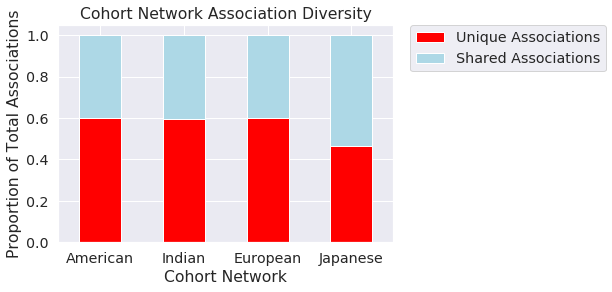

In [112]:
EdgeStatsDF2.plot(kind='bar', stacked=True, x='Network', color=['red','lightblue'])
plt.ylabel("Proportion of Total Associations")
plt.xlabel("Cohort Network")
plt.title("Cohort Network Association Diversity")
sns.set(font_scale=1.3)
rcParams['figure.figsize'] = 11,8.27
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.xticks(rotation=0)

## Look at edge share percentages

In [113]:
def pullSharePercentage(df):
    df2 = df.copy()
    
    tempDict = {"Cohort":[], "American":[], "Indian":[], "European":[], "Japanese":[]}
    
    for column in df2.columns:
        
        tempDict['Cohort'].append(column)
        
        for column2 in df2.columns:
                
                if column == column2:
                    tempDict[column2].append(1)
                else:
                    tempDict[column2].append(len(df2[[column,column2]].dropna())/len(df2[column].dropna()))
        
    tempDF = pd.DataFrame(data=tempDict).set_index("Cohort")
    return tempDF

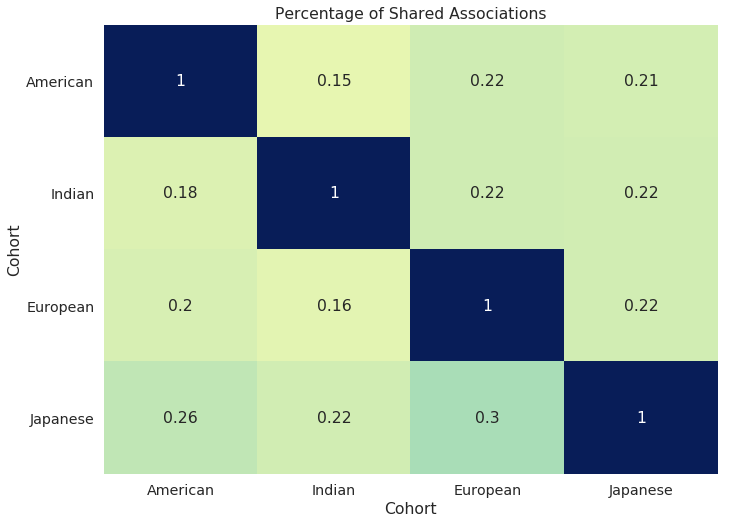

In [244]:
sns.set(font_scale=1.3)
rcParams['figure.figsize'] = 11,8.27
ax = sns.heatmap(pullSharePercentage(compDF), vmin=0, vmax=1, annot=True, cmap="YlGnBu", cbar=False)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.title("Percentage of Shared Associations")
plt.xlabel("Cohort")
plt.show()

## Look at Edge Distributions

In [115]:
def pullAssociationDistribution(network, cohortname):
    tempDict = {'Association_Weight':[], 'Cohort':[]}
    if len(list(network.edges)) < 1:
        tempDict['Association_Weight'].append(0.0)
        tempDict['Cohort'].append(cohortname)
    else:
        for i in network.edges:
            tempDict['Association_Weight'].append(network.edges[i]['weight'])
            tempDict['Cohort'].append(cohortname)
    pdDF = pd.DataFrame(data=tempDict)
    return(pdDF)

In [116]:
americanComp = pullAssociationDistribution(americanNetwork, 'American')
indianComp = pullAssociationDistribution(indianNetwork, 'Indian')
europeanComp = pullAssociationDistribution(europeanNetwork, 'European')
japaneseComp = pullAssociationDistribution(japaneseNetwork, 'Japanese')
smallSpecies_associations = pd.concat([americanComp, indianComp,europeanComp ,japaneseComp ])

In [117]:
tempDict = {"Association_Weight":[], 'Cohort':[]}
for i in compDF.dropna().columns:
    for x in list(compDF.dropna()[i]):
        tempDict['Cohort'].append(i)
        tempDict['Association_Weight'].append(x)
tempDF = pd.DataFrame(data=tempDict)

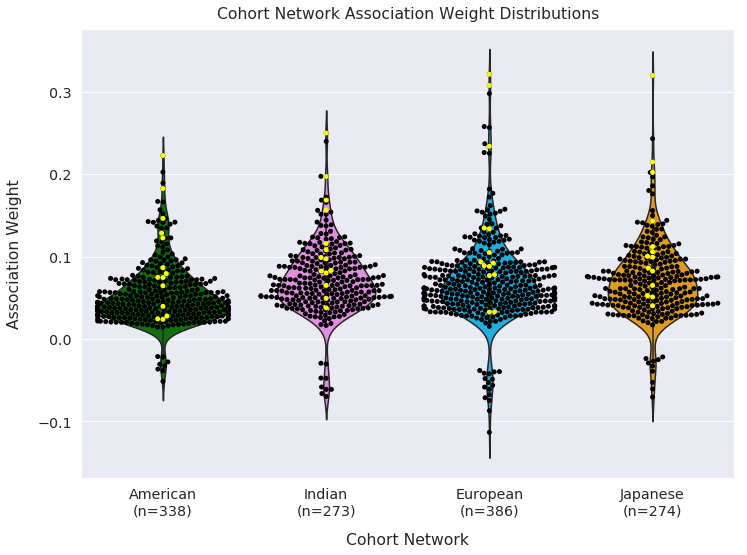

In [118]:
palette ={"American":'green', "European":'deepskyblue', "Indian":'violet', "Japanese":'orange'}

rcParams['figure.figsize'] = 11.7,8.27
ax = sns.violinplot(x="Cohort", y="Association_Weight", data=smallSpecies_associations, palette=palette)
ax = sns.swarmplot(x="Cohort", y="Association_Weight", data=smallSpecies_associations, color="black")
ax = sns.swarmplot(x="Cohort", y="Association_Weight", data=tempDF, color="yellow")

testList = []
for x in list(ax.get_xticklabels()):
    testList.append(str(str(x.get_text())+"\n"+"(n="+str(len(smallSpecies_associations[smallSpecies_associations['Cohort']==str(x.get_text())]))+")"))
ax.set_xticklabels(testList)

sns.set(font_scale=1.3)
ax.set_xlabel('Cohort Network',labelpad=15)
ax.set_ylabel('Association Weight', labelpad=15)
ax.set_title('Cohort Network Association Weight Distributions', pad=10)
plt.show()

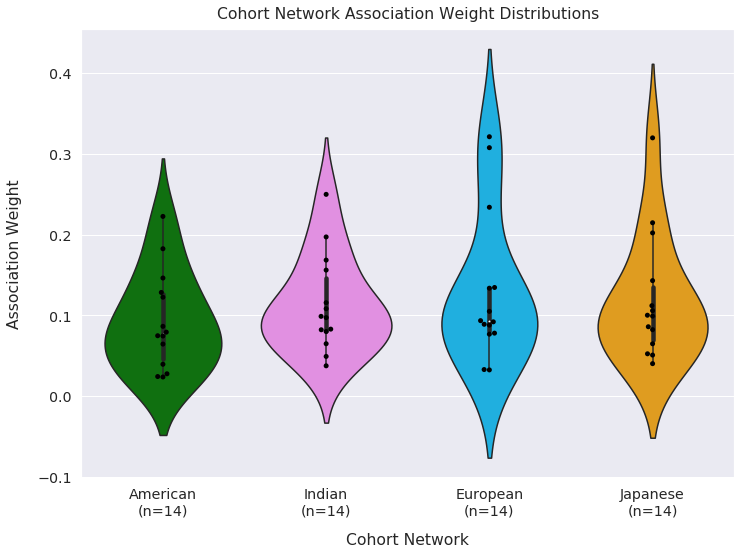

In [119]:
palette ={"American":'green', "European":'deepskyblue', "Indian":'violet', "Japanese":'orange'}

rcParams['figure.figsize'] = 11.7,8.27
ax = sns.violinplot(x="Cohort", y="Association_Weight", data=tempDF, palette=palette)
ax = sns.swarmplot(x="Cohort", y="Association_Weight", data=tempDF, color="black")

testList = []
for x in list(ax.get_xticklabels()):
    testList.append(str(str(x.get_text())+"\n"+"(n="+str(len(tempDF[tempDF['Cohort']==str(x.get_text())]))+")"))
ax.set_xticklabels(testList)

sns.set(font_scale=1.3)
ax.set_xlabel('Cohort Network',labelpad=15)
ax.set_ylabel('Association Weight', labelpad=15)
ax.set_title('Cohort Network Association Weight Distributions', pad=10)
plt.show()

## Look at Taxonomic Levels

In [120]:
def SpecieslineageEdge(df):
    tempDict={"Network":[], "Total_Associations":[], "Positive_WithinGenus":[], "Negative_WithinGenus":[], "Positive_WithinFamily":[], "Negative_WithinFamily":[],  "Positive_WithinOrder":[], "Negative_WithinOrder":[],  "Positive_WithinClass":[], "Negative_WithinClass":[], "Positive_WithinPhylum":[], "Negative_WithinPhylum":[], "Positive_OutsidePhylum":[], "Negative_OutsidePhylum":[], "Positive_WithinGramType":[], "Negative_WithinGramType":[], 'Positive_OutsideGramType':[],'Negative_OutsideGramType':[]}
    
    #You get names from this one
    df2 = df.copy() #reset_index().copy() 
    
    cohortNames = {x:x for x in df.columns}
    
    df2['level_0'] = 'temp'
    df2['level_1'] = 'temp'

    for row in df2.index:
        df2.at[row, 'level_0'] = str(row.split("<-->")[0].strip())
        df2.at[row, 'level_1'] = str(row.split("<-->")[1].strip())
        
    df2.reset_index().drop(columns=['index'], inplace=True)
    
    for cohort in cohortNames.keys():
        
        tempDict['Network'].append(cohort)
        tempDict['Total_Associations'].append(len(df2[[cohortNames[cohort]]].dropna())) 

        PG = 0
        NG = 0
        
        PF = 0
        NF = 0
        
        PO = 0
        NO = 0
        
        PC = 0
        NC = 0
        
        PP = 0
        NP = 0
        
        PGT = 0
        PoGT = 0
        NGT = 0
        NoGT = 0
        PoP = 0
        NoP = 0
        
        for row in df2[["level_0","level_1",cohortNames[cohort]]].dropna().index:
            
            #CHECK GRAM TYPE:
            if float(df2.at[row, cohortNames[cohort]]) > 0:
                try:
                    if BacterialPhylums[accTaxDictDF3.at[df2.at[row, 'level_0'].replace(".","-"), 'Phylum']] == BacterialPhylums[accTaxDictDF3.at[df2.at[row, 'level_1'].replace(".","-"),'Phylum']]:
                        PGT += 1
                    else:
                        PoGT += 1
                except:
                    print("OUCH GRAM POS")
                    print(df2.loc[row])
            else:
                try:
                    if BacterialPhylums[accTaxDictDF3.at[df2.at[row, 'level_0'].replace(".","-"), 'Phylum']] == BacterialPhylums[accTaxDictDF3.at[df2.at[row, 'level_1'].replace(".","-"),'Phylum']]:
                        NGT += 1
                    else:
                        NoGT += 1
                except:
                    print("OUCH GRAM Neg")
                    
            #################################################################################################
            #IF THE ASSOCIATION IS POSITIVE
            if float(df2.at[row, cohortNames[cohort]]) > 0:
                
                #CHECK GENUS
                if accTaxDictDF3.at[df2.at[row,'level_0'].replace(".","-"), 'Genus'] == accTaxDictDF3.at[df2.at[row,'level_1'].replace(".","-"), 'Genus']:
                    PG += 1
                    
                #CHECK Family
                elif accTaxDictDF3.at[df2.at[row,'level_0'].replace(".","-"), 'Family'] == accTaxDictDF3.at[df2.at[row,'level_1'].replace(".","-"), 'Family']:
                    PF += 1
                            
                #CHECK Order
                elif accTaxDictDF3.at[df2.at[row,'level_0'].replace(".","-"), 'Order'] == accTaxDictDF3.at[df2.at[row,'level_1'].replace(".","-"), 'Order']:
                    PO += 1
                    
                #CHECK Class
                elif accTaxDictDF3.at[df2.at[row,'level_0'].replace(".","-"), 'Class'] == accTaxDictDF3.at[df2.at[row,'level_1'].replace(".","-"), 'Class']:
                    PC += 1
                                
                #CHECK PHYLUM
                elif accTaxDictDF3.at[df2.at[row,'level_0'].replace(".","-"), 'Phylum'] == accTaxDictDF3.at[df2.at[row,'level_1'].replace(".","-"), 'Phylum']:
                    PP += 1
                            
                #CHECK OUTSIDE PHYLUM
                elif accTaxDictDF3.at[df2.at[row,'level_0'].replace(".","-"), 'Phylum'] != accTaxDictDF3.at[df2.at[row,'level_1'].replace(".","-"), 'Phylum']:
                    PoP += 1
                            
                else:
                    print("WHAT?")
                        
                        
            #IF THE ASSOCIATION IS NEGATIVE
            else:
                #CHECK GENUS
                if accTaxDictDF3.at[df2.at[row,'level_0'].replace(".","-"), 'Genus'] == accTaxDictDF3.at[df2.at[row,'level_1'].replace(".","-"), 'Genus']:
                    NG += 1
                                
                #CHECK Family
                elif accTaxDictDF3.at[df2.at[row,'level_0'].replace(".","-"), 'Family'] == accTaxDictDF3.at[df2.at[row,'level_1'].replace(".","-"), 'Family']:
                    NF += 1
                            
                #CHECK Order
                elif accTaxDictDF3.at[df2.at[row,'level_0'].replace(".","-"), 'Order'] == accTaxDictDF3.at[df2.at[row,'level_1'].replace(".","-"), 'Order']:
                    NO += 1
                    
                #CHECK Class
                elif accTaxDictDF3.at[df2.at[row,'level_0'].replace(".","-"), 'Class'] == accTaxDictDF3.at[df2.at[row,'level_1'].replace(".","-"), 'Class']:
                    NC += 1
                                
                #CHECK PHYLUM
                elif accTaxDictDF3.at[df2.at[row,'level_0'].replace(".","-"), 'Phylum'] == accTaxDictDF3.at[df2.at[row,'level_1'].replace(".","-"), 'Phylum']:
                    NP += 1
                            
                #CHECK OUTSIDE PHYLUM
                elif accTaxDictDF3.at[df2.at[row,'level_0'].replace(".","-"), 'Phylum'] != accTaxDictDF3.at[df2.at[row,'level_1'].replace(".","-"), 'Phylum']:
                    NoP += 1
                            
                else:
                    print("WHAT?")
        
        tempDict['Positive_WithinGenus'].append(PG)
        tempDict['Negative_WithinGenus'].append(NG)
        
        tempDict['Positive_WithinFamily'].append(PF)
        tempDict['Negative_WithinFamily'].append(NF)
        
        tempDict['Positive_WithinOrder'].append(PO)
        tempDict['Negative_WithinOrder'].append(NO)
        
        tempDict['Positive_WithinClass'].append(PC)
        tempDict['Negative_WithinClass'].append(NC)
        
        tempDict['Positive_WithinPhylum'].append(PP)
        tempDict['Negative_WithinPhylum'].append(NP)
        
        tempDict['Positive_OutsidePhylum'].append(PoP)
        tempDict['Negative_OutsidePhylum'].append(NoP)
        tempDict['Positive_WithinGramType'].append(PGT)
        tempDict['Negative_WithinGramType'].append(NGT)
        tempDict['Positive_OutsideGramType'].append(PoGT)
        tempDict['Negative_OutsideGramType'].append(NoGT)
            
    tempDF = pd.DataFrame(data=tempDict)
    tempDF.replace(0, np.nan, inplace=True)
    tempDF.set_index("Network", inplace=True)
    tempDF.dropna(thresh=1, axis=0, inplace=True)
    tempDF.replace(np.nan, 0, inplace=True)
    return tempDF

In [121]:
taxLook = SpecieslineageEdge(compDF)
taxLook

,Total_Associations,Positive_WithinGenus,Negative_WithinGenus,Positive_WithinFamily,Negative_WithinFamily,Positive_WithinOrder,Negative_WithinOrder,Positive_WithinClass,Negative_WithinClass,Positive_WithinPhylum,Negative_WithinPhylum,Positive_OutsidePhylum,Negative_OutsidePhylum,Positive_WithinGramType,Negative_WithinGramType,Positive_OutsideGramType,Negative_OutsideGramType
Network,,,,,,,,,,,,,,,,,
American,338,118,0.0,39,0.0,122,2,0.0,0.0,1,0.0,50,6.0,280,2,50,6.0
Indian,273,59,0.0,50,0.0,108,5,0.0,0.0,10,0.0,37,4.0,233,5,31,4.0
European,386,93,0.0,102,1.0,122,7,0.0,0.0,11,0.0,42,8.0,330,12,40,4.0
Japanese,274,83,0.0,59,0.0,85,10,0.0,0.0,19,0.0,18,0.0,254,10,10,0.0


In [122]:
taxLook100 = SpecieslineageEdge(compDF.dropna())
taxLook100

,Total_Associations,Positive_WithinGenus,Negative_WithinGenus,Positive_WithinFamily,Negative_WithinFamily,Positive_WithinOrder,Negative_WithinOrder,Positive_WithinClass,Negative_WithinClass,Positive_WithinPhylum,Negative_WithinPhylum,Positive_OutsidePhylum,Negative_OutsidePhylum,Positive_WithinGramType,Negative_WithinGramType,Positive_OutsideGramType,Negative_OutsideGramType
Network,,,,,,,,,,,,,,,,,
American,14,10,0.0,3,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14,0.0,0.0,0.0
Indian,14,10,0.0,3,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14,0.0,0.0,0.0
European,14,10,0.0,3,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14,0.0,0.0,0.0
Japanese,14,10,0.0,3,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14,0.0,0.0,0.0


In [123]:
def pullAssocationPercentages(df):
    df2 = df.copy()
    tempDict2={"Network":[], "Count":[], "Tax_Association":[]}
    for row in df2.index:
        TotalCount = df2.loc[row].sum()
        for column in df2.columns:
            tempDict2['Network'].append(row)
            tempDict2['Count'].append(df2.at[row,column]/TotalCount)
            tempDict2['Tax_Association'].append(column)
    tempDF2 = pd.DataFrame(data=tempDict2)
    return(tempDF2)

In [124]:
def pullGramPercentages(df):
    df2 = df.copy()
    tempDict3={"Network":[], "Percentage":[], "Gram_Association":[]}
    for row in df2.index:
        TotalCount = df2.loc[row].sum()
        for column in df2.columns:
            tempDict3['Network'].append(row)
            tempDict3['Percentage'].append(df2.at[row,column]/TotalCount)
            tempDict3['Gram_Association'].append(column)
    tempDF3 = pd.DataFrame(data=tempDict3)
    return(tempDF3)

In [125]:
taxSpecies = taxLook[["Positive_WithinGenus", "Negative_WithinGenus", "Positive_WithinFamily", "Negative_WithinFamily",  "Positive_WithinOrder", "Negative_WithinOrder",  "Positive_WithinClass", "Negative_WithinClass", "Positive_WithinPhylum", "Negative_WithinPhylum", "Positive_OutsidePhylum", "Negative_OutsidePhylum"]].copy()
GTSpecies = taxLook[['Positive_WithinGramType','Negative_WithinGramType','Positive_OutsideGramType','Negative_OutsideGramType']].copy()
taxSpecies2 = pullAssocationPercentages(taxSpecies)
GTSpecies2 = pullGramPercentages(GTSpecies)

In [126]:
taxSpeciesClean = taxSpecies2.copy()

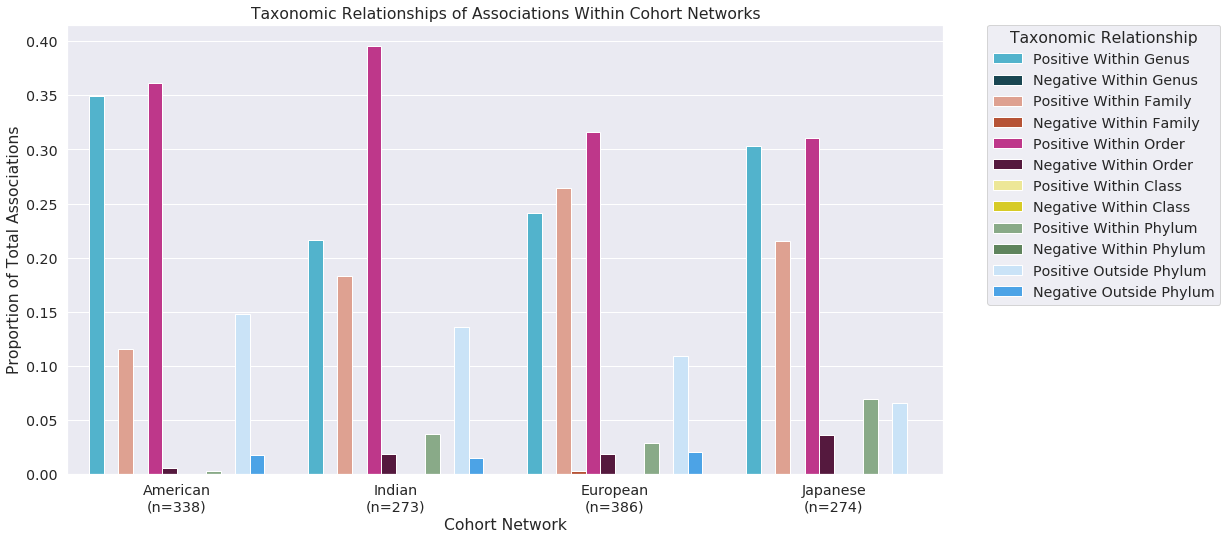

In [127]:
barpalette= {"Positive_WithinGenus":'#3EBFE0', "Negative_WithinGenus":'#0F4C5C', "Positive_WithinFamily":'#EB9A84', "Negative_WithinFamily":'#CB4721',  "Positive_WithinOrder":'#D4218F', "Negative_WithinOrder":'#5F0F40',  "Positive_WithinClass":'#FBF389', "Negative_WithinClass":'#F4E409', "Positive_WithinPhylum":'#84B082', "Negative_WithinPhylum":'#598A56', "Positive_OutsidePhylum":'#C2E4FF', "Negative_OutsidePhylum":'#33A7FF'}
sns.set(font_scale=1.3)
rcParams['figure.figsize'] = 15.7,8.27
ax = sns.barplot(data=taxSpecies2, x='Network', hue='Tax_Association', y='Count', palette=barpalette)
plt.ylabel("Proportion of Total Associations")
plt.xlabel("Cohort Network")
plt.title("Taxonomic Relationships of Associations Within Cohort Networks")

L = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Taxonomic Relationship')
L.get_texts()[0].set_text('Positive Within Genus')
L.get_texts()[1].set_text('Negative Within Genus')
L.get_texts()[2].set_text('Positive Within Family')
L.get_texts()[3].set_text('Negative Within Family')
L.get_texts()[4].set_text('Positive Within Order')
L.get_texts()[5].set_text('Negative Within Order')
L.get_texts()[6].set_text('Positive Within Class')
L.get_texts()[7].set_text('Negative Within Class')
L.get_texts()[8].set_text('Positive Within Phylum')
L.get_texts()[9].set_text('Negative Within Phylum')
L.get_texts()[10].set_text('Positive Outside Phylum')
L.get_texts()[11].set_text('Negative Outside Phylum')

plt.xticks(rotation=0)
testList2 = []
for x in list(ax.get_xticklabels()):
    testList2.append(str(str(x.get_text())+"\n"+"(n="+str(len(smallSpecies_associations[smallSpecies_associations['Cohort']==str(x.get_text())]))+")"))
ax.set_xticklabels(testList2)
plt.show()

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

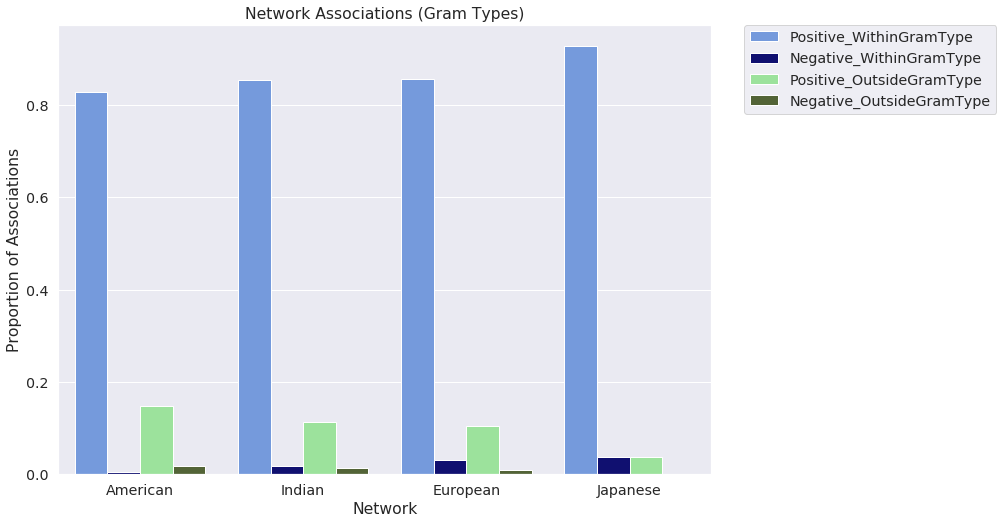

In [128]:
sns.set(font_scale=1.3)
rcParams['figure.figsize'] = 11.7,8.27
palette2= {'Positive_WithinGramType':'cornflowerblue','Negative_WithinGramType':'navy','Positive_OutsideGramType':'lightgreen','Negative_OutsideGramType':'darkolivegreen'}
sns.barplot(data=GTSpecies2, x='Network', hue='Gram_Association', y='Percentage', palette=palette2)
plt.ylabel("Proportion of Associations")
plt.title("Network Associations (Gram Types)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=0)

## Look at Network Properties

In [129]:
from networkx.algorithms.community.quality import modularity

In [130]:
def emergentNetworkProperties(network1, cohortName, partitions):
    columnNames = {"Network":[],  "Nodes":[], "Edges":[], "Positive_Edges":[], "Negative_Edges":[], "Nodes_in_Largest_Component":[], "Single_Nodes":[], "Density":[], "Average_Degree":[], "Modularity":[], "Connectedness":[], "ASPL":[], "Genera_Assortativity":[], "Degree_Assortativity":[], "Transitivity":[]}
    ################################################
    columnNames['Network'].append(cohortName)
    columnNames['Nodes'].append(len(network1.nodes))
    columnNames['Edges'].append(len(network1.edges))
    ################################################
    positiveEdges = []
    negativeEdges = [] 
    
    weights = nx.get_edge_attributes(network1, 'weight')
    
    for edge in list(network1.edges):
        if float(weights[edge]) > 0.0:
            positiveEdges.append(weights[edge])               
        else:
            negativeEdges.append(weights[edge])
            
    columnNames['Positive_Edges'].append(len(positiveEdges))
    columnNames['Negative_Edges'].append(len(negativeEdges))
    
    #Find average degree of all nodes
    degrees = []
    for i in network1.nodes:
        degrees.append(network1.degree(i))
    avgDeg = np.mean(degrees)
    columnNames['Average_Degree'].append(avgDeg)
    
    #Find Average Shortest Path Length (Average of over all connected components)
    Gcc = sorted(nx.connected_components(network1), key=len, reverse=True)
    L2 = []
    for g in Gcc:
        if len(g) > 1:
            G0 = network1.subgraph(g)
            L2.append(nx.average_shortest_path_length(G0))
        else:
            continue
            weight=None
            
    columnNames['ASPL'] = np.mean(L2)
    
    columnNames['Modularity'].append(modularity(network1, partitions))
    
    #Find out how many nodes have no connections
    counttt = 0
    for i in list(nx.connected_components(network1)):
        if len(i) >1:
            continue
        else:
            counttt+=1
    columnNames['Single_Nodes'] = counttt
    
    #Find how many nodes are in the biggest component of the graph
    networkComponents = sorted(nx.connected_components(network1), key=len, reverse=True)
    bigcomponent = network1.subgraph(networkComponents[0])
    columnNames['Nodes_in_Largest_Component'] = len(list(nx.connected_components(bigcomponent))[0])
    
    
    ###################################################################################
    #Some statistics only work on connected components. Check if the network is connected.
    if nx.is_connected(network1):
        columnNames['Connectedness'].append("True")
        columnNames['Degree_Assortativity'].append(nx.degree_assortativity_coefficient(network1))
        columnNames['Transitivity'].append(nx.transitivity(network1))
        columnNames['Degree_Assortativity'].append(nx.degree_assortativity_coefficient(network1))
        columnNames['Genera_Assortativity'].append(nx.attribute_assortativity_coefficient(network1, 'genera'))
        columnNames['Transitivity'].append(nx.transitivity(network1))
        columnNames['Density'].append(nx.density(network1))
    else:
        columnNames['Connectedness'].append("False")
        columnNames['Degree_Assortativity'].append(nx.degree_assortativity_coefficient(network1))
        columnNames['Genera_Assortativity'].append(nx.attribute_assortativity_coefficient(network1, 'genera'))
        columnNames['Transitivity'].append(nx.transitivity(network1))
        columnNames['Density'].append(nx.density(network1))
        
    cohortDF = pd.DataFrame(columnNames)
    return(cohortDF)

In [131]:
# Partitions were already found the code block below loads those partitions
#americanPartitions = list(asyn_lpa_communities(americanNetwork, weight='weight'))
#indianPartitions = list(asyn_lpa_communities(indianNetwork, weight='weight'))
#europeanPartitions = list(asyn_lpa_communities(europeanNetwork, weight='weight'))
#japanesePartitions = list(asyn_lpa_communities(japaneseNetwork, weight='weight'))

In [132]:
americanPartitions_temp = set(line.strip() for line in open('./DataFiles/GGM/americanPartitions.txt'))
indianPartitions_temp = set(line.strip() for line in open('./DataFiles/GGM/indianPartitions.txt'))
europeanPartitions_temp = set(line.strip() for line in open('./DataFiles/GGM/europeanPartitions.txt'))
japanesePartitions_temp = set(line.strip() for line in open('./DataFiles/GGM/japanesePartitions.txt'))

americanPartitions = []
indianPartitions = []
europeanPartitions = []
japanesePartitions = []

for x in americanPartitions_temp:
        tempSet = list()
        for y in x.split(","):
            tempSet.append(y.split("'")[1])
        americanPartitions.append(set(tempSet))     
        
for x in indianPartitions_temp:
        tempSet = list()
        for y in x.split(","):
            tempSet.append(y.split("'")[1])
        indianPartitions.append(set(tempSet))   
        
for x in europeanPartitions_temp:
        tempSet = list()
        for y in x.split(","):
            tempSet.append(y.split("'")[1])
        europeanPartitions.append(set(tempSet)) 
        
for x in japanesePartitions_temp:
        tempSet = list()
        for y in x.split(","):
            tempSet.append(y.split("'")[1])
        japanesePartitions.append(set(tempSet))   

In [133]:
americanNetPropDF = emergentNetworkProperties(americanNetwork, "American", americanPartitions).set_index("Network")
indianNetPropDF = emergentNetworkProperties(indianNetwork, "Indian", indianPartitions).set_index("Network")
europeanNetPropDF = emergentNetworkProperties(europeanNetwork, "European", europeanPartitions).set_index("Network")
japaneseNetPropDF = emergentNetworkProperties(japaneseNetwork, "Japanese", japanesePartitions).set_index("Network")

PropertyCompDF = pd.concat([americanNetPropDF, indianNetPropDF,europeanNetPropDF, japaneseNetPropDF])
#PropertyCompDF.to_csv("./DataFiles/GGM/Comparisons/AllComp_NetworkStruct.csv")

In [134]:
PropertyCompDF

,Nodes,Edges,Positive_Edges,Negative_Edges,Nodes_in_Largest_Component,Single_Nodes,Density,Average_Degree,Modularity,Connectedness,ASPL,Genera_Assortativity,Degree_Assortativity,Transitivity
Network,,,,,,,,,,,,,,
American,202,338,330,8,71,105,0.016649,3.346535,0.474739,False,1.539250,0.144392,0.337704,0.487374
Indian,202,273,264,9,82,98,0.013448,2.702970,0.666851,False,1.874499,0.163392,0.329600,0.452241
European,202,386,370,16,134,53,0.019014,3.821782,0.680941,False,1.369122,0.196079,0.157558,0.353107
Japanese,202,274,264,10,87,85,0.013497,2.712871,0.755207,False,1.444254,0.242277,0.307897,0.470558


In [135]:
from networkx.algorithms.community.quality import performance
print("American Module Detection Performance: "+str(performance(americanNetwork, americanPartitions)))
print("Indian Module Detection Performance: "+str(performance(indianNetwork, indianPartitions)))
print("European Module Detection Performance: "+str(performance(europeanNetwork, europeanPartitions)))
print("Japanese Module Detection Performance: "+str(performance(japaneseNetwork, japanesePartitions)))

American Module Detection Performance: 0.9621200926062755
Indian Module Detection Performance: 0.9845820402935817
European Module Detection Performance: 0.9423673710654648
Japanese Module Detection Performance: 0.9809368996601152


## Add Attributes to networks

In [136]:
for x in compDF.dropna().index:
    americanNetwork[str(x.split("<-->")[0])][str(x.split("<-->")[1])]['RetainedEdge'] = True
    indianNetwork[str(x.split("<-->")[0])][str(x.split("<-->")[1])]['RetainedEdge'] = True
    europeanNetwork[str(x.split("<-->")[0])][str(x.split("<-->")[1])]['RetainedEdge'] = True
    japaneseNetwork[str(x.split("<-->")[0])][str(x.split("<-->")[1])]['RetainedEdge'] = True

In [137]:
allSpeciesCols = allSpecies.copy()
allSpeciesCols.replace(0.0, np.nan, inplace=True)
allSpeciesCols.dropna(axis=1, inplace=True)
List100 = list(allSpeciesCols.columns)
List100.remove('Cohort')
print(List100)
print(len(List100))

['Bacteroides_coprocola', 'Bacteroides_plebeius', 'Blautia_obeum', 'Clostridiales_bacterium_CCNA10', 'Coprococcus_comes', 'Eubacterium_ramulus', 'Eubacterium_rectale', 'Fusicatenibacter_saccharivorans', 'Lachnospiraceae_bacterium_GAM79', 'Roseburia_faecis', 'Roseburia_inulinivorans', 'Ruminococcus_faecis', 'Ruminococcus_lactaris', 'Tyzzerella_nexilis']
14


In [138]:
newDict100 = {}
for y in List100:
    newDict100[y] = {"CoreSpecies":True}

for i in List100:
    nx.set_node_attributes(americanNetwork, newDict100)
    nx.set_node_attributes(indianNetwork, newDict100)
    nx.set_node_attributes(europeanNetwork, newDict100)
    nx.set_node_attributes(japaneseNetwork, newDict100)

## Look at Nodes

In [139]:
def nodeAndEdgeStats(network1, abundanceDF, cohortName, level):

    columnNames = {"Bacterial_"+level:[], "Mean_Relative_Abundance":[],"Total_Edges":[], "Positive_Edges":[], "Negative_Edges":[], "Triangles":[], "Degree_Centrality":[], "Clustering_Coefficient":[], "Harmonic_Centrality":[], "Betweenness_Centrality":[], "Cohort":[]}

    triangles = nx.triangles(network1)
    
    dcentrality = nx.degree_centrality(network1)
    
    hcentrality = nx.harmonic_centrality(network1)
        
    bcentrality = nx.betweenness_centrality(network1, normalized=True)
    
    nodes = network1.nodes
    
    weights = nx.get_edge_attributes(network1, 'weight')
    
    clusteringc = nx.clustering(network1)
    
    for i in nodes:
        
        positiveEdges = []
        negativeEdges = []
        totalEdges = []
        
        for edge in network1.edges:
            if edge[0] == i or edge[1] == i:
                if weights[edge] > 0.0:
                    positiveEdges.append(weights[edge])
                    totalEdges.append(weights[edge])
                else:
                    totalEdges.append(weights[edge])
                    negativeEdges.append(weights[edge])
            else:
                continue
        
        columnNames['Bacterial_'+level].append(i)
        columnNames['Clustering_Coefficient'].append(clusteringc[i])
        columnNames['Mean_Relative_Abundance'].append(abundanceDF[i].mean())
        columnNames['Total_Edges'].append(len(totalEdges))
        columnNames['Positive_Edges'].append(len(positiveEdges))
        columnNames['Negative_Edges'].append(len(negativeEdges))
        columnNames['Triangles'].append(triangles[i])
        columnNames['Degree_Centrality'].append(dcentrality[i])
        columnNames['Harmonic_Centrality'].append(hcentrality[i])
        columnNames['Betweenness_Centrality'].append(bcentrality[i])
        columnNames['Cohort'].append(cohortName)

    cohortDF = pd.DataFrame(data=columnNames).set_index("Bacterial_"+level)
    return(cohortDF)

In [140]:
americanNodeDF = nodeAndEdgeStats(americanNetwork, americanSpecies, "American", "Species")
indianNodeDF = nodeAndEdgeStats(indianNetwork, indianSpecies, "Indian", "Species")
europeanNodeDF = nodeAndEdgeStats(europeanNetwork, europeanSpecies, "European", "Species")
japaneseNodeDF = nodeAndEdgeStats(japaneseNetwork, japaneseSpecies, "Japanese", "Species")

In [141]:
aNoEdge = americanNodeDF[americanNodeDF['Total_Edges']==0].copy()
iNoEdge = indianNodeDF[indianNodeDF['Total_Edges']==0].copy()
eNoEdge = europeanNodeDF[europeanNodeDF['Total_Edges']==0].copy()
jNoEdge = japaneseNodeDF[japaneseNodeDF['Total_Edges']==0].copy()

allNoEdge = pd.concat([aNoEdge,iNoEdge,eNoEdge,jNoEdge])
bacList = list(allNoEdge.index)

from collections import Counter
noEdgeBacteria = []
for x,y in Counter(bacList).items():
    if y == 4:
        noEdgeBacteria.append(x)

In [142]:
accTaxDictDF3.at['bacterium_LF-3','Phylum'] = "Firmicutes"
nodeTaxDF = accTaxDictDF3[["Phylum","Class","Order","Family","Genus"]].copy()
nodeList = [x for x in americanNetwork.nodes() if x not in noEdgeBacteria]
nodeList2 = list(nodeTaxDF.loc[nodeList].sort_values(by=['Phylum','Class','Order','Family','Genus'],ascending=True).index)
print("Phylums: "+str(len(set(nodeTaxDF.loc[nodeList].sort_values(by=['Phylum','Class','Order','Family','Genus'],ascending=True)['Phylum']))))
print("Classes: "+str(len(set(nodeTaxDF.loc[nodeList].sort_values(by=['Phylum','Class','Order','Family','Genus'],ascending=True)['Class']))))
print("Orders: "+str(len(set(nodeTaxDF.loc[nodeList].sort_values(by=['Phylum','Class','Order','Family','Genus'],ascending=True)['Order']))))
print("Families: "+str(len(set(nodeTaxDF.loc[nodeList].sort_values(by=['Phylum','Class','Order','Family','Genus'],ascending=True)['Family']))))
print("Genera: "+str(len(set(nodeTaxDF.loc[nodeList].sort_values(by=['Phylum','Class','Order','Family','Genus'],ascending=True)['Genus']))))

Phylums: 4
Classes: 9
Orders: 12
Families: 26
Genera: 81


In [143]:
barpalette= {"Positive_WithinGenus":'#FC342D', "Negative_WithinGenus":'#C3D3F7', "Positive_WithinFamily":'#ABB392', "Negative_WithinFamily":'#669614',  "Positive_WithinOrder":'#719B83', "Negative_WithinOrder":'#7C9FF2',  "Positive_WithinClass":'#7770A0', "Negative_WithinClass":'#755878', "Positive_WithinPhylum":'#72414F', "Negative_WithinPhylum":'#702926', "Positive_OutsidePhylum":'#B9F255', "Negative_OutsidePhylum":'black'}

In [144]:
americanEdgeColorList = []
for x in list(americanNetwork.edges(data=True)):
    if float(x[2]['weight']) > 0:
        americanEdgeColorList.append('lightblue')
    else:
        americanEdgeColorList.append('orange')
        
indianEdgeColorList = []
for x in list(indianNetwork.edges(data=True)):
    if float(x[2]['weight']) > 0:
        indianEdgeColorList.append('lightblue')
    else:
        indianEdgeColorList.append('orange')
        
europeanEdgeColorList = []
for x in list(europeanNetwork.edges(data=True)):
    if float(x[2]['weight']) > 0:
        europeanEdgeColorList.append('lightblue')
    else:
        europeanEdgeColorList.append('orange')
        
japaneseEdgeColorList = []
for x in list(japaneseNetwork.edges(data=True)):
    if float(x[2]['weight']) > 0:
        japaneseEdgeColorList.append('lightblue')
    else:
        japaneseEdgeColorList.append('orange')

In [145]:
nodeColor = {}
for i in nodeList2:
    if nodeTaxDF.loc[i]['Phylum'] == 'Actinobacteria':
        nodeColor[i]="#db57ff"
    elif nodeTaxDF.loc[i]['Phylum'] =='Bacteroidetes':
        nodeColor[i]="#24e0b8"
    elif nodeTaxDF.loc[i]['Phylum'] =='Firmicutes':
        nodeColor[i]="#ffcc51"
    elif nodeTaxDF.loc[i]['Phylum'] =='Proteobacteria':
        nodeColor[i]="#ff3031"
    else:
        nodeColor[i]="#ff3031"

In [146]:
legend = {"Actinobacteria":"#db57ff","Bacteroidetes":"#118AB2","Firmicutes":"#06D6A0","Proteobacteria":"#ff3031","Unclassified_Bacteria":"#EF476F"}

In [147]:
americanNodeSize = []
indianNodeSize = []
europeanNodeSize = []
japaneseNodeSize = []

for i in nodeList2:
    americanNodeSize.append(float(americanNetwork.degree(i)+1)*4)
    indianNodeSize.append(float(indianNetwork.degree(i)+1)*4)
    europeanNodeSize.append(float(europeanNetwork.degree(i)+1)*4)
    japaneseNodeSize.append(float(japaneseNetwork.degree(i)+1)*4)

In [148]:
ComDegSpecies = pd.read_csv("./DataFiles/GGM/highDegreeSpecies").rename(columns={"Unnamed: 0":"Cohort"}).set_index("Cohort")
ComDegSpecies.replace(0, np.nan, inplace=True)
ComDegSpecies

,Acetivibrio ethanolgignens,Alistipes finegoldii,Alistipes shahii,Alistipes timonensis,Bacteroides barnesiae,Bacteroides coprocola,Bacteroides faecichinchillae,Bacteroides helcogenes,Bacteroides pectinophilus,Bacteroides pyogenes,...,Pseudoflavonifractor capillosus,Roseburia intestinalis,Ruthenibacterium lactatiformans,Streptococcus salivarius,Streptococcus sp FDAARGOS 192,Streptococcus sp oral taxon 431,Subdoligranulum variabile,Tyzzerella nexilis,Veillonella dispar,bacterium LF-3
Cohort,,,,,,,,,,,,,,,,,,,,,
American,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,1.0,1.0,NaN,1.0,NaN,NaN,1.0,1.0,NaN,NaN
Indian,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN
European,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0
Japanese,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN


In [149]:
def buildLabels(cohortName):
    highDegreeLabels = {}
    for i in nodeList2:
        if i in list(ComDegSpecies.loc[cohortName].dropna().index):
            highDegreeLabels[i]=str(i.replace("_", " "))
        else:
            highDegreeLabels[i]=' '
    return(highDegreeLabels)

In [150]:
countkeepTrack = 1
for i in nodeList2:
    print(str(countkeepTrack)+": "+i.replace("_"," ")+", ")
    countkeepTrack+=1

1: Schaalia odontolytica, 
2: Bifidobacterium catenulatum, 
3: Bifidobacterium adolescentis, 
4: Bifidobacterium pseudocatenulatum, 
5: Bifidobacterium longum, 
6: Cellulomonas carbonis, 
7: Collinsella aerofaciens, 
8: Eggerthella lenta, 
9: Bacteroides cellulosilyticus, 
10: Bacteroides helcogenes, 
11: Bacteroides barnesiae, 
12: Bacteroides zoogleoformans, 
13: Bacteroides fluxus, 
14: Bacteroides salanitronis, 
15: Bacteroides nordii, 
16: Bacteroides caccae, 
17: Bacteroides stercoris, 
18: Bacteroides fragilis, 
19: Bacteroides thetaiotaomicron, 
20: Bacteroides salyersiae, 
21: Bacteroides heparinolyticus, 
22: Bacteroides reticulotermitis, 
23: Bacteroides coprocola, 
24: Bacteroides ovatus, 
25: Bacteroides coprophilus, 
26: Bacteroides plebeius, 
27: Bacteroides dorei, 
28: Bacteroides vulgatus, 
29: Bacteroides caecimuris, 
30: Bacteroides faecichinchillae, 
31: Bacteroides uniformis, 
32: Bacteroides pyogenes, 
33: Mediterranea massiliensis, 
34: Barnesiella viscericola, 


In [151]:
numberedHubs = {}
hubNum = 1

for i in nodeList2:
    if i.replace("_"," ") in sorted(list(ComDegSpecies.columns)):
        numberedHubs[i] = hubNum
        hubNum +=1
    else:
        hubNum +=1
        continue

In [152]:
newHubList = []
nodeName = []
x=1
for i in nodeList2:
    if i in list(numberedHubs.keys()):
        if 'pectinophilus' in i:
            newHubList.append(str(x)+": ["+str(i).replace("_"," ").split(" ")[0]+"]"+" "+str(str(i).replace("_"," ").split(" ")[1]))
            nodeName.append(i)
            x+=1
        else:
            newHubList.append(str(x)+": "+str(i).replace("_"," "))
            nodeName.append(i)
            x+=1
    else:
        continue

In [153]:
ComDegSpecies2 = ComDegSpecies[[x.replace("_"," ") for x in nodeName]].copy()

In [154]:
ComDegSpecies2

,Bifidobacterium catenulatum,Bacteroides helcogenes,Bacteroides barnesiae,Bacteroides salanitronis,Bacteroides thetaiotaomicron,Bacteroides coprocola,Bacteroides faecichinchillae,Bacteroides pyogenes,Mediterranea massiliensis,Culturomica massiliensis,...,Oscillibacter ruminantium,Acetivibrio ethanolgignens,Bittarella massiliensis,Flavonifractor plautii,Pseudoflavonifractor capillosus,Ruthenibacterium lactatiformans,Subdoligranulum variabile,Bacteroides pectinophilus,Veillonella dispar,bacterium LF-3
Cohort,,,,,,,,,,,,,,,,,,,,,
American,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN
Indian,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,1.0,1.0,...,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,1.0,NaN
European,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,1.0,NaN,1.0,NaN,1.0
Japanese,1.0,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [155]:
goodNumberedHubs = []
goodNumHubsDict = {}
for x,y in numberedHubs.items():
    if 'pectinophilus' in x:
        goodNumberedHubs.append(str(y)+": ["+str(x).replace("_"," ").split(" ")[0]+"] "+str(x).replace("_"," ").split(" ")[1])
        goodNumHubsDict[str(x)] = str(y)
    else:
        goodNumberedHubs.append(str(y)+": "+str(x).replace("_"," "))
        goodNumHubsDict[str(x)] = str(y)

In [156]:
def buildLabels2(cohortName,hubList):
    hubList2 = hubList.copy()
    hubDict = {}
    
    for i in hubList2:
        hubDict[i] = goodNumHubsDict[i]

    highDegreeLabels = {}
    for i in nodeList2:
        if i in hubList2:
            highDegreeLabels[i]=hubDict[i]
        else:
            highDegreeLabels[i]=' '
            
    return(highDegreeLabels)

In [157]:
americanHubs2 = buildLabels2('American',[x.replace(" ","_") for x in list(ComDegSpecies2.loc['American'].dropna().index)])
indianHubs2 = buildLabels2('Indian',[x.replace(" ","_") for x in list(ComDegSpecies2.loc['Indian'].dropna().index)])
europeanHubs2 = buildLabels2('European',[x.replace(" ","_") for x in list(ComDegSpecies2.loc['European'].dropna().index)])
japaneseHubs2 = buildLabels2('Japanese',[x.replace(" ","_") for x in list(ComDegSpecies2.loc['Japanese'].dropna().index)])

In [158]:
Phylumlegend = {"Actinobacteria":"#db57ff","Bacteroidetes":"#24e0b8","Firmicutes":"#ffcc51","Proteobacteria":"#ff3031"}

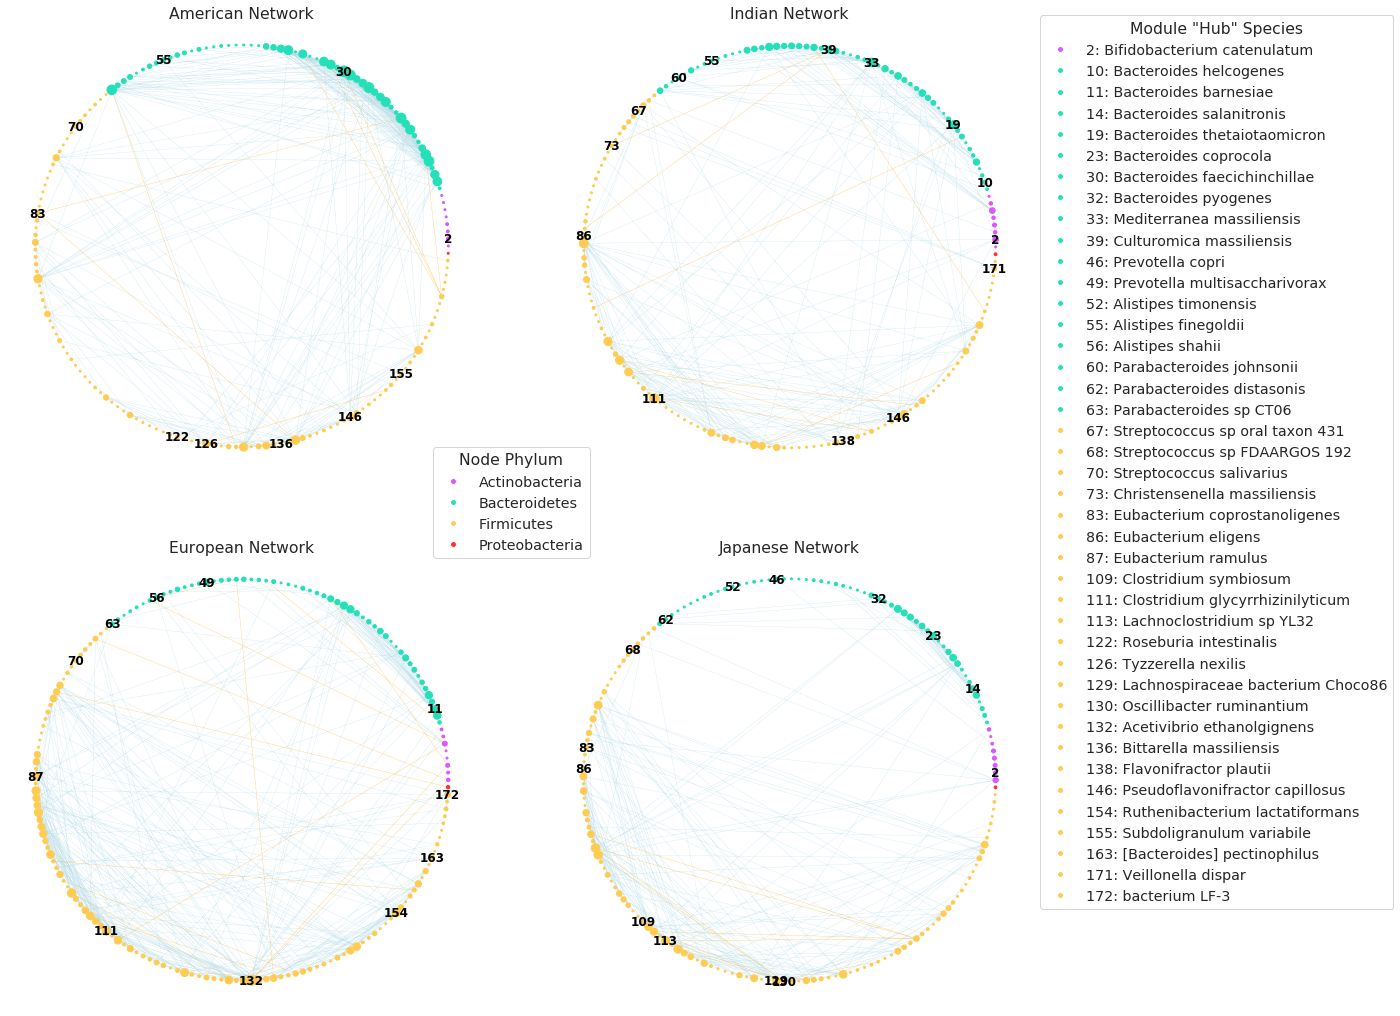

In [159]:
G=nx.grid_2d_graph(4,4)  #4x4 grid
from matplotlib.lines import Line2D

posit = nx.circular_layout(nodeList2)
fig, ax = plt.subplots(figsize=(18,18))

ax1 = plt.subplot(221)
nx.draw_networkx_nodes(americanNetwork, pos=posit, nodelist=nodeList2, node_size=americanNodeSize, with_labels=False, node_color=list(nodeColor.values()), font_size=10)
nx.draw_networkx_edges(americanNetwork, pos=posit, width=.2, edge_color=americanEdgeColorList)
nx.draw_networkx_labels(americanNetwork, pos=posit,horizontalalignment='center', labels=americanHubs2,font_size=12,font_weight='bold',font_color='black')

plt.title("American Network")
ax.set_facecolor('white')
ax.axis('off')
ax1.set_facecolor('white')

ax2 = plt.subplot(222)
nx.draw_networkx_nodes(indianNetwork, pos=posit, nodelist=nodeList2, node_size=indianNodeSize, with_labels=False, node_color=list(nodeColor.values()), font_size=10)
nx.draw_networkx_edges(indianNetwork, pos=posit, width=.2, edge_color=indianEdgeColorList)
nx.draw_networkx_labels(indianNetwork,pos=posit, labels=indianHubs2,font_size=12,font_weight='bold',font_color='black')
plt.title("Indian Network")
ax2.set_facecolor('white')

ax3 = plt.subplot(223)
nx.draw_networkx_nodes(europeanNetwork, pos=posit, nodelist=nodeList2, node_size=europeanNodeSize, with_labels=False, node_color=list(nodeColor.values()), font_size=10)
nx.draw_networkx_edges(europeanNetwork, pos=posit, width=.2, edge_color=europeanEdgeColorList)
nx.draw_networkx_labels(europeanNetwork,pos=posit, labels=europeanHubs2,font_size=12,font_weight='bold',font_color='black')
plt.title("European Network")
ax3.set_facecolor('white')

ax4 = plt.subplot(224)
nx.draw_networkx_nodes(japaneseNetwork, pos=posit, nodelist=nodeList2, node_size=japaneseNodeSize, with_labels=False, node_color=list(nodeColor.values()), font_size=10)
nx.draw_networkx_edges(japaneseNetwork, pos=posit, width=.2, edge_color=japaneseEdgeColorList)
nx.draw_networkx_labels(japaneseNetwork,pos=posit, labels=japaneseHubs2,font_size=12,font_weight='bold',font_color='black')
plt.title("Japanese Network")
ax4.set_facecolor('white')


#Builds Legend
hubs = nodeName
lines = [Line2D([0], [0], marker='o', color='white',markerfacecolor=nodeColor[c], linewidth=3) for c in hubs]
labels = goodNumberedHubs
firstLeg = plt.legend(lines, labels, bbox_to_anchor=(1.05, 2.22), loc=2, borderaxespad=0., title='Module "Hub" Species', facecolor='w')


lines2 = [Line2D([0], [0], marker='o', color='white', markerfacecolor=Phylumlegend[c], linewidth=3) for c in list(Phylumlegend.keys())]
labels2 = list(Phylumlegend.keys())
newLeg = plt.legend(lines2, labels2, bbox_to_anchor=(-.28, 1.25), loc=2, borderaxespad=0., title='Node Phylum', facecolor='w')

plt.gca().add_artist(firstLeg)
plt.show()

## Look at Cliques

In [160]:
Pos_american = americanNetwork.copy()
Pos_indian = indianNetwork.copy()
Pos_european = europeanNetwork.copy()
Pos_japanese = japaneseNetwork.copy()

Neg_american = americanNetwork.copy()
Neg_indian = indianNetwork.copy()
Neg_european = europeanNetwork.copy()
Neg_japanese = japaneseNetwork.copy()

In [161]:
for i in list(Pos_american.edges.data()):
    if float(i[2]['weight']) >0:
        continue
    else:
        Pos_american.remove_edge(i[0], i[1])
        
for i in list(Pos_indian.edges.data()):
    if float(i[2]['weight']) >0:
        continue
    else:
        Pos_indian.remove_edge(i[0], i[1])
        
for i in list(Pos_european.edges.data()):
    if float(i[2]['weight']) >0:
        continue
    else:
        Pos_european.remove_edge(i[0], i[1])

for i in list(Pos_japanese.edges.data()):
    if float(i[2]['weight']) >0:
        continue
    else:
        Pos_japanese.remove_edge(i[0], i[1])

In [162]:
for x in list(Neg_american.edges.data()):
    if float(x[2]['weight']) < 0:
        continue
    else:
        Neg_american.remove_edge(x[0], x[1])
        
for x in list(Neg_indian.edges.data()):
    if float(x[2]['weight']) < 0:
        continue
    else:
        Neg_indian.remove_edge(x[0], x[1])
        
for x in list(Neg_european.edges.data()):
    if float(x[2]['weight']) < 0:
        continue
    else:
        Neg_european.remove_edge(x[0], x[1])
        
for x in list(Neg_japanese.edges.data()):
    if float(x[2]['weight']) < 0:
        continue
    else:
        Neg_japanese.remove_edge(x[0], x[1])

In [163]:
print(len(list(americanNetwork.edges.data())))
print(len(list(indianNetwork.edges.data())))
print(len(list(europeanNetwork.edges.data())))
print(len(list(japaneseNetwork.edges.data())))
print("\n")
print(len(list(Pos_american.edges.data())))
print(len(list(Pos_indian.edges.data())))
print(len(list(Pos_european.edges.data())))
print(len(list(Pos_japanese.edges.data())))
print("\n")
print(len(list(Neg_american.edges.data())))
print(len(list(Neg_indian.edges.data())))
print(len(list(Neg_european.edges.data())))
print(len(list(Neg_japanese.edges.data())))

338
273
386
274


330
264
370
264


8
9
16
10


## View Negative Associations

In [164]:
negativeSpecies  = []
for i in list(Neg_american.edges):
    for x in i:
        negativeSpecies.append(x)
        
for i in list(Neg_indian.edges):
    for x in i:
        negativeSpecies.append(x)
        
for i in list(Neg_european.edges):
    for x in i:
        negativeSpecies.append(x)
        
for i in list(Neg_japanese.edges):
    for x in i:
        negativeSpecies.append(x)
        
negativeSpecies2 = set(negativeSpecies)

In [165]:
negativeGenera = []
negativeOrder = []
negativePhylum = []
for i in negativeSpecies2:
    negativeGenera.append(accTaxDictDF3.at[i.replace(".","-"), 'Genus'])
    negativeOrder.append(accTaxDictDF3.at[i.replace(".","-"), 'Order'])
    negativePhylum.append(accTaxDictDF3.at[i.replace(".","-"), 'Phylum'])

negativeGenera2 = set(negativeGenera)
negativeOrder2 = set(negativeOrder)
negativePhylum2 = set(negativePhylum)

In [166]:
negativeSpeciesAssociationDF = pd.DataFrame(index=sorted(list(negativeSpecies2)), columns=sorted(list(negativeSpecies2)))
negativeSpeciesAssociationDF.fillna(0.0, inplace=True)

negativeGeneraAssociationDF = pd.DataFrame(index=sorted(list(negativeGenera2)), columns=sorted(list(negativeGenera2)))
negativeGeneraAssociationDF.fillna(0.0, inplace=True)

negativeOrderAssociationDF = pd.DataFrame(index=sorted(list(negativeOrder2)), columns=sorted(list(negativeOrder2)))
negativeOrderAssociationDF.fillna(0.0, inplace=True)

negativePhylumAssociationDF = pd.DataFrame(index=sorted(list(negativePhylum2)), columns=sorted(list(negativePhylum2)))
negativePhylumAssociationDF.fillna(0.0, inplace=True)

In [167]:
def fillNEGDF(negList, dfSpecies, dfGenus, dfOrder, dfPhylum):
    
    totalNeg = len(list(negList.edges))
    
    dfspecies2 = dfSpecies.copy()
    dfGenus2 = dfGenus.copy()
    dfOrder2 = dfOrder.copy()
    dfPhylum2 = dfPhylum.copy()


    for i in list(negList.edges):
        dfspecies2.at[i[0],i[1]]+= float(1/totalNeg)
        dfGenus2.at[accTaxDictDF3.at[i[0].replace(".","-"), 'Genus'],accTaxDictDF3.at[i[1].replace(".","-"), 'Genus']]+= float(1/totalNeg)
        dfOrder2.at[accTaxDictDF3.at[i[0].replace(".","-"), 'Order'],accTaxDictDF3.at[i[1].replace(".","-"), 'Order']]+= float(1/totalNeg)
        dfPhylum2.at[accTaxDictDF3.at[i[0].replace(".","-"), 'Phylum'],accTaxDictDF3.at[i[1].replace(".","-"), 'Phylum']]+= float(1/totalNeg)
        
    return (dfspecies2,dfGenus2,dfOrder2,dfPhylum2)

In [168]:
americanNegSpecies, americanNegGenus,americanNegOrder, americanNegPhylum = fillNEGDF(Neg_american,negativeSpeciesAssociationDF,negativeGeneraAssociationDF,negativeOrderAssociationDF,negativePhylumAssociationDF)
indianNegSpecies, indianNegGenus, indianNegOrder, indianNegPhylum = fillNEGDF(Neg_indian,negativeSpeciesAssociationDF,negativeGeneraAssociationDF,negativeOrderAssociationDF,negativePhylumAssociationDF)
europeanNegSpecies, europeanNegGenus, europeanNegOrder, europeanNegPhylum = fillNEGDF(Neg_european,negativeSpeciesAssociationDF,negativeGeneraAssociationDF,negativeOrderAssociationDF,negativePhylumAssociationDF)
japaneseNegSpecies, japaneseNegGenus, japaneseNegOrder, japaneseNegPhylum = fillNEGDF(Neg_japanese,negativeSpeciesAssociationDF,negativeGeneraAssociationDF,negativeOrderAssociationDF,negativePhylumAssociationDF)

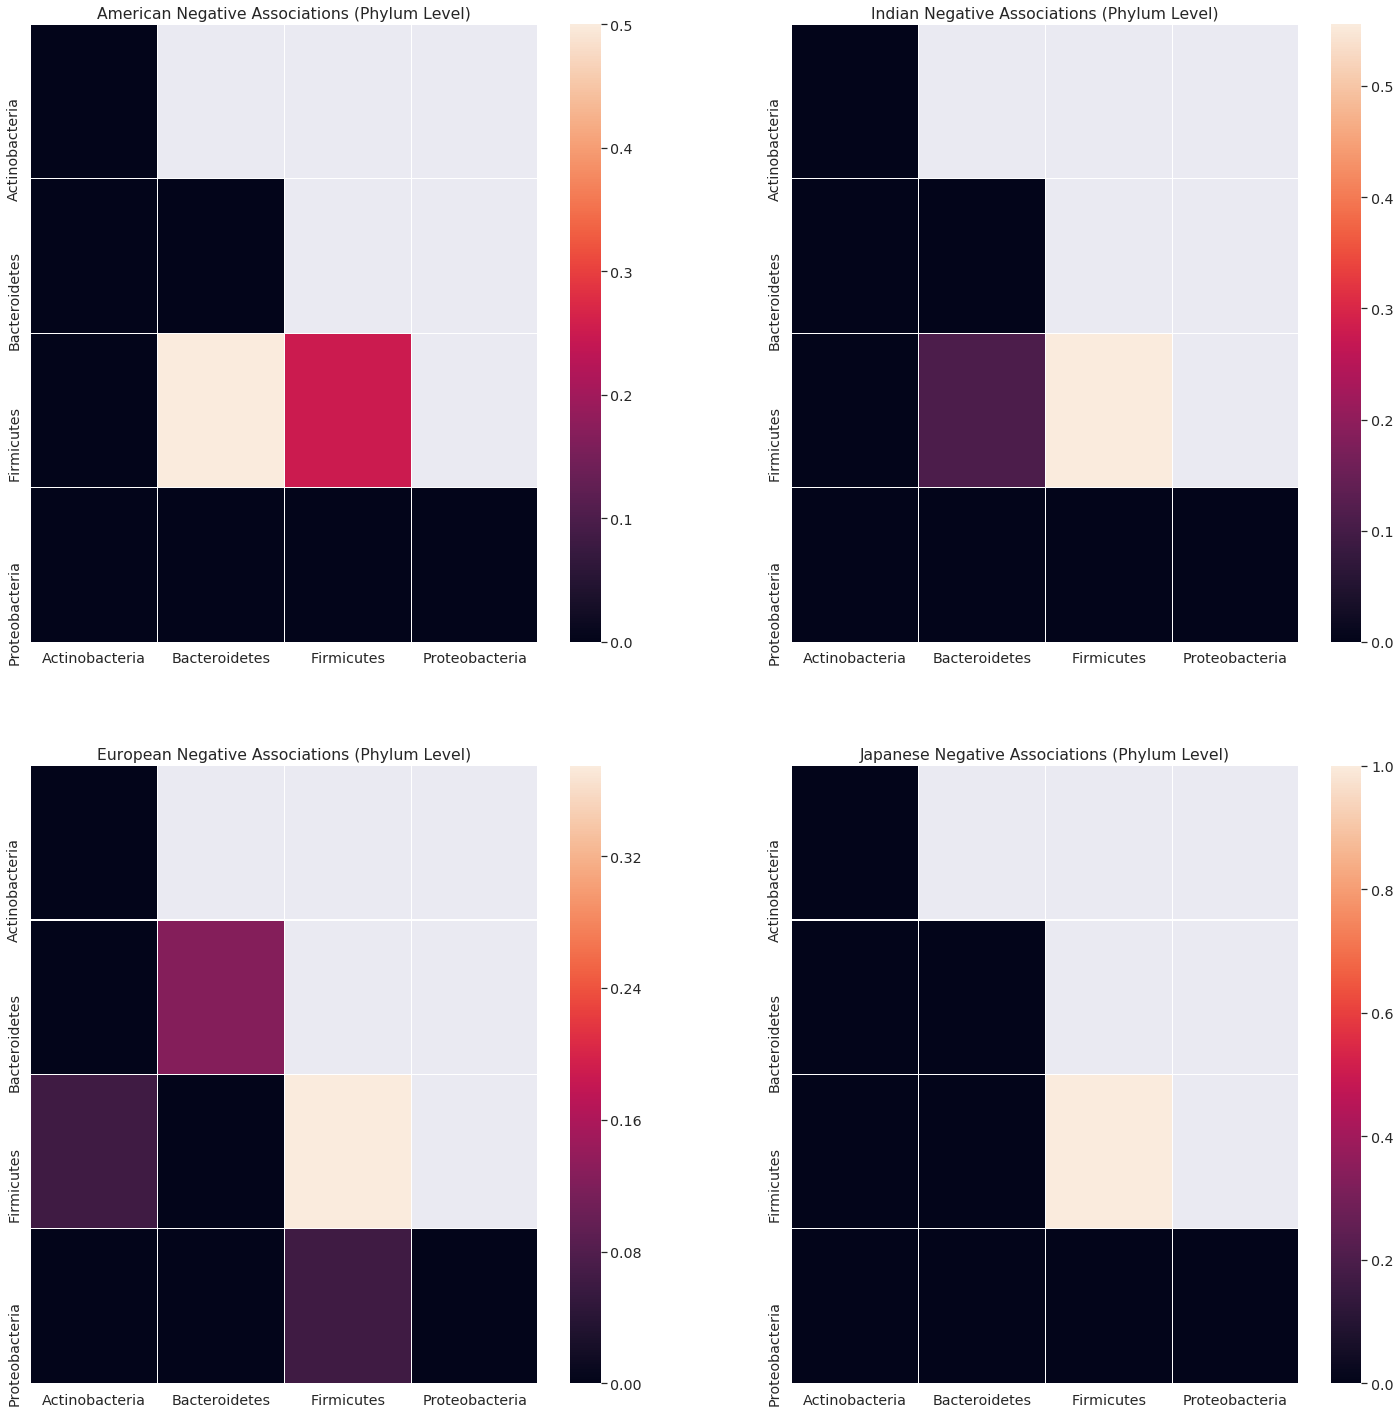

In [169]:
fig, axs = plt.subplots(2, 2, figsize=(25,25))
sns.heatmap(americanNegPhylum.where(np.tril(np.ones(americanNegPhylum.shape)).astype(np.bool)), annot=False, xticklabels=1, yticklabels=1, linewidths=.05,ax=axs[0, 0])
sns.heatmap(indianNegPhylum.where(np.tril(np.ones(indianNegPhylum.shape)).astype(np.bool)),annot=False, xticklabels=1, yticklabels=1, linewidths=.05,ax=axs[0, 1])
sns.heatmap(europeanNegPhylum.where(np.tril(np.ones(europeanNegPhylum.shape)).astype(np.bool)),annot=False, xticklabels=1, yticklabels=1, linewidths=.05,ax=axs[1, 0])
sns.heatmap(japaneseNegPhylum.where(np.tril(np.ones(japaneseNegPhylum.shape)).astype(np.bool)),annot=False, xticklabels=1, yticklabels=1, linewidths=.05,ax=axs[1, 1])

axs[0,0].set_title('American Negative Associations (Phylum Level)')
axs[0,1].set_title('Indian Negative Associations (Phylum Level)')
axs[1,0].set_title('European Negative Associations (Phylum Level)')
axs[1,1].set_title('Japanese Negative Associations (Phylum Level)')
plt.show()

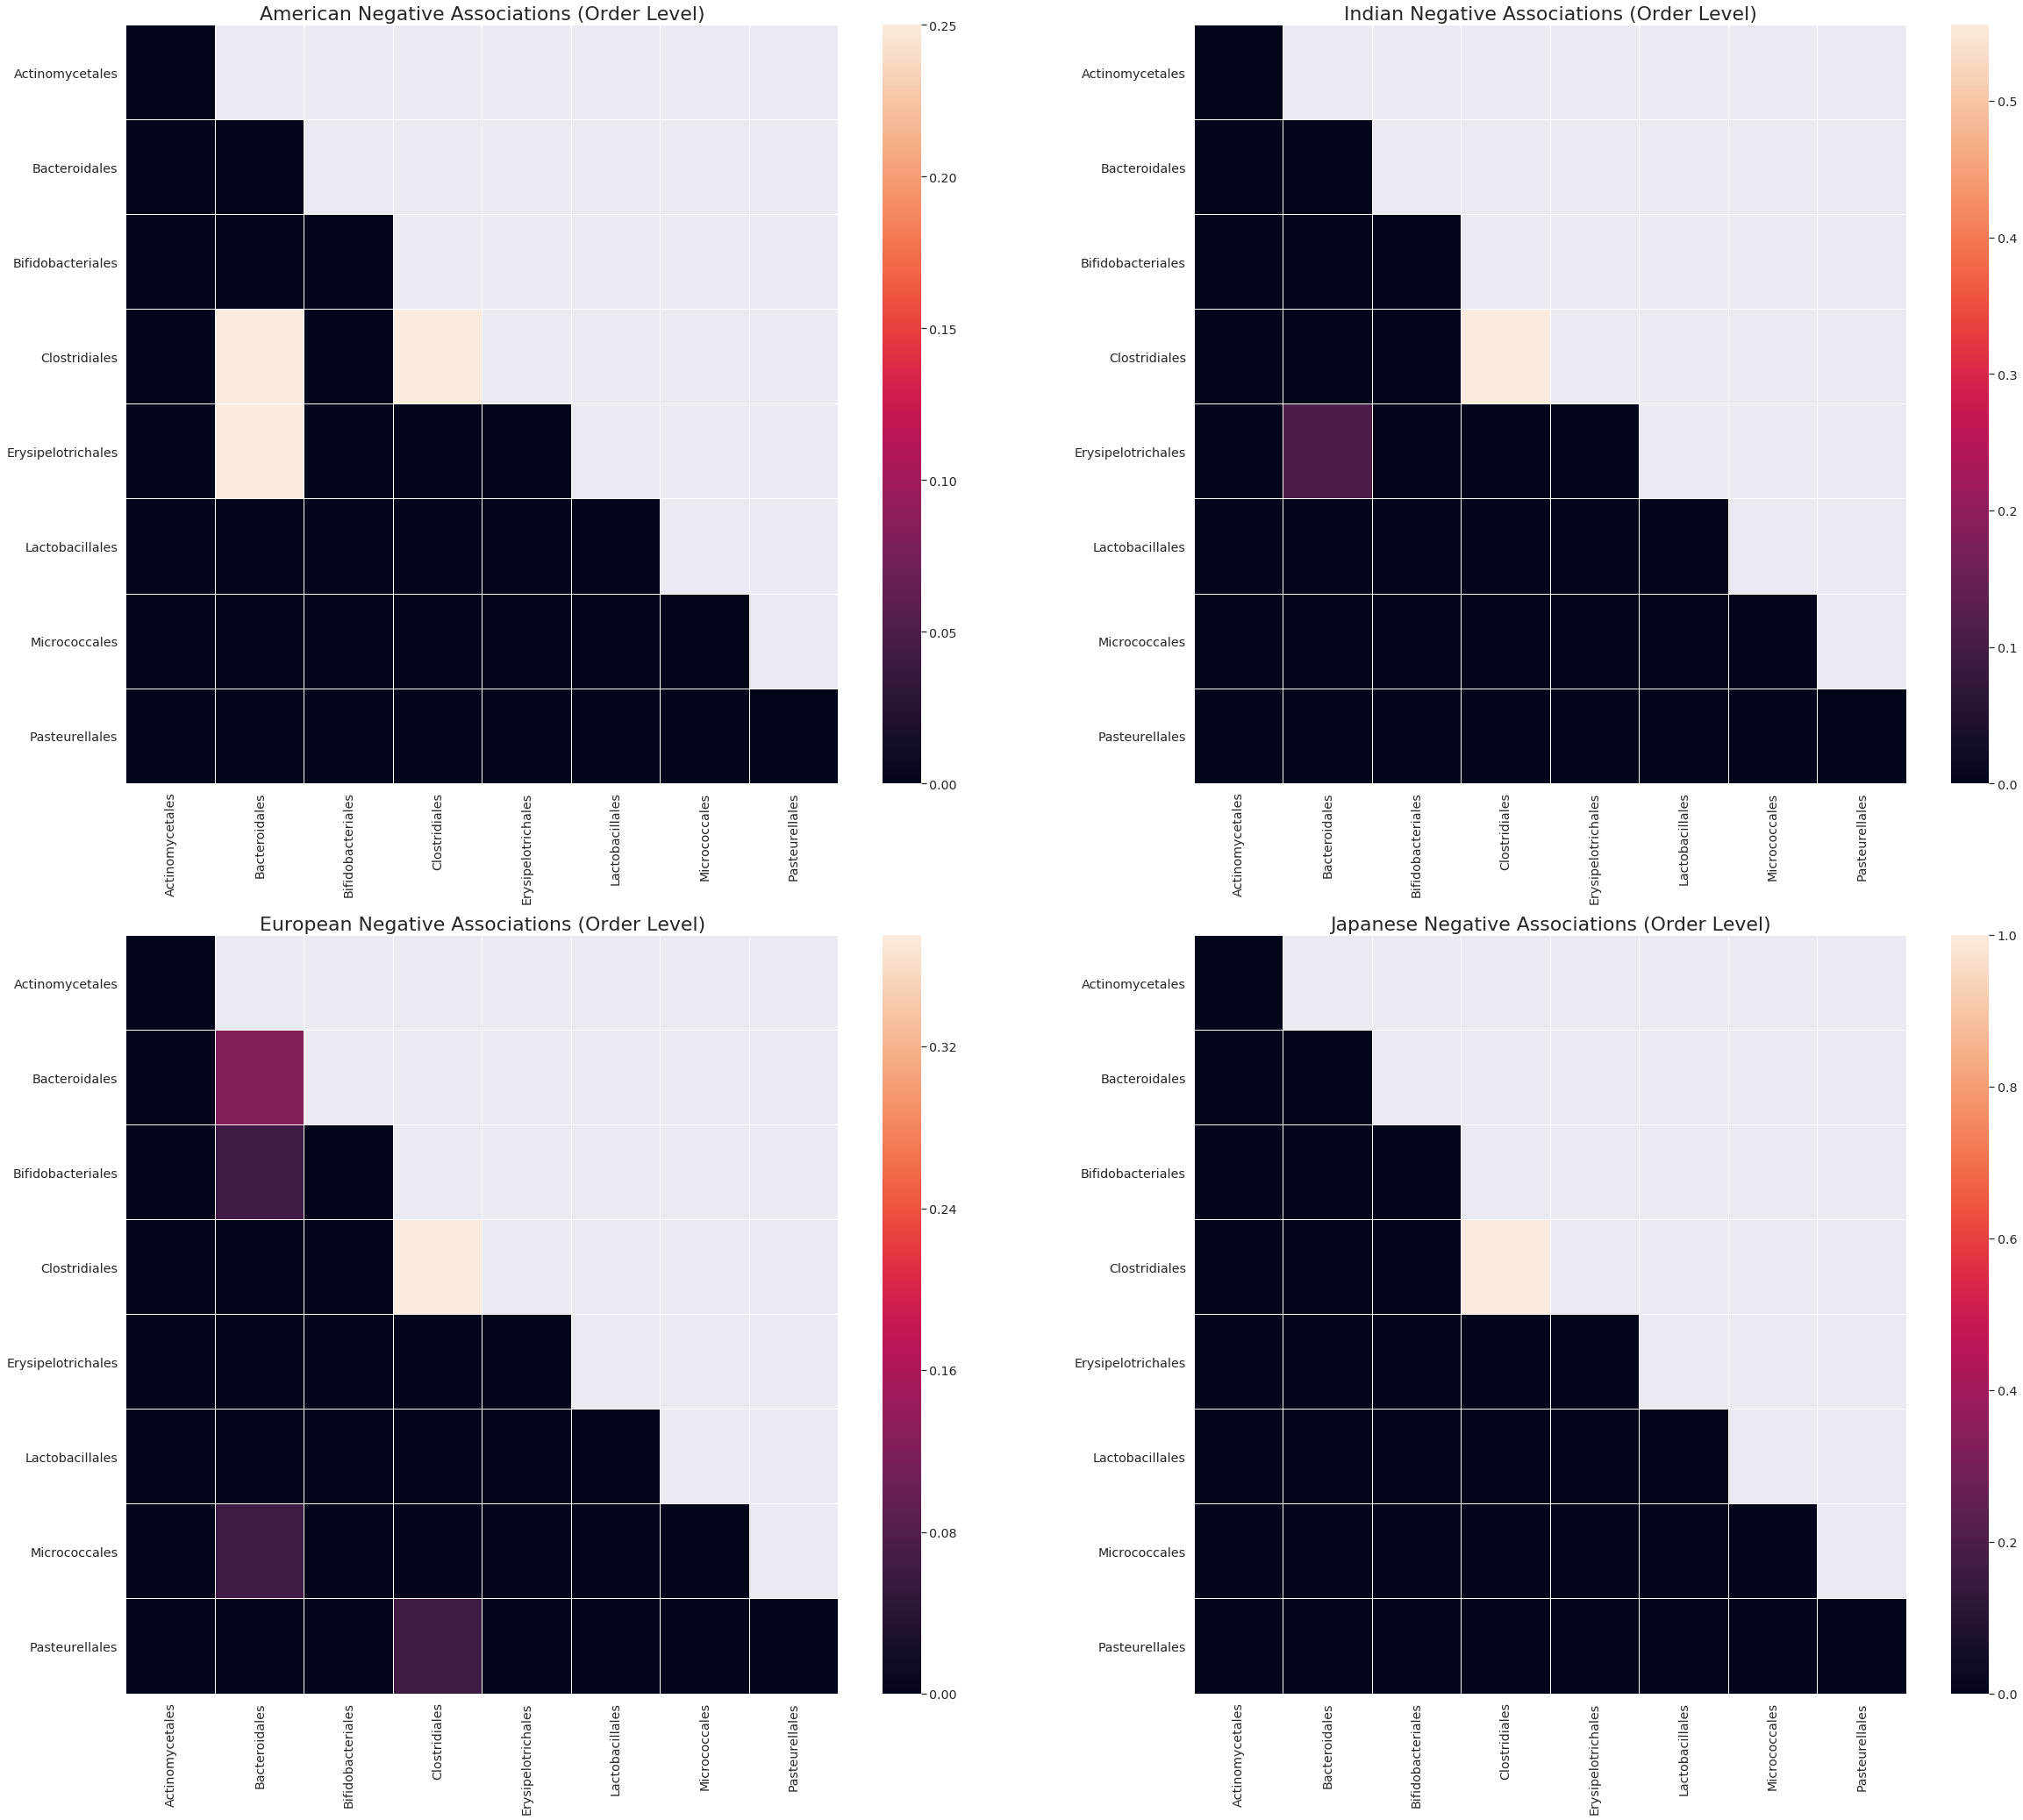

In [170]:
fig, axs = plt.subplots(2, 2, figsize=(40,35))
sns.heatmap(americanNegOrder.where(np.tril(np.ones(americanNegOrder.shape)).astype(np.bool)), annot=False, xticklabels=1, yticklabels=1, linewidths=.05,ax=axs[0, 0])
sns.heatmap(indianNegOrder.where(np.tril(np.ones(indianNegOrder.shape)).astype(np.bool)),annot=False, xticklabels=1, yticklabels=1, linewidths=.05,ax=axs[0, 1])
sns.heatmap(europeanNegOrder.where(np.tril(np.ones(europeanNegOrder.shape)).astype(np.bool)),annot=False, xticklabels=1, yticklabels=1, linewidths=.05,ax=axs[1, 0])
sns.heatmap(japaneseNegOrder.where(np.tril(np.ones(japaneseNegOrder.shape)).astype(np.bool)),annot=False, xticklabels=1, yticklabels=1, linewidths=.05,ax=axs[1, 1])

axs[0,0].set_title('American Negative Associations (Order Level)', size=22)
axs[0,1].set_title('Indian Negative Associations (Order Level)', size=22)
axs[1,0].set_title('European Negative Associations (Order Level)', size=22)
axs[1,1].set_title('Japanese Negative Associations (Order Level)', size=22)
plt.show()

## FInd Cliques

In [171]:
americanCliques = list(nx.find_cliques(Pos_american))
indianCliques = list(nx.find_cliques(Pos_indian))
europeanCliques = list(nx.find_cliques(Pos_european))
japaneseCliques = list(nx.find_cliques(Pos_japanese))

In [172]:
tempDict = {"Cohort":[], "CliqueSize":[]}
tempDict2 = {"Cohort":[], "CommunitySize":[]}

In [173]:
for x in americanCliques:
    tempDict['Cohort'].append("American")
    tempDict['CliqueSize'].append(int(len(x)))

for y in indianCliques:
    tempDict['Cohort'].append("Indian")
    tempDict['CliqueSize'].append(int(len(y)))
        
for e in europeanCliques:
    tempDict['Cohort'].append("European")
    tempDict['CliqueSize'].append(int(len(e)))
    
for j in japaneseCliques:
    tempDict['Cohort'].append("Japanese")
    tempDict['CliqueSize'].append(int(len(j)))

In [174]:
tempDF1 = pd.DataFrame(data=tempDict)
tempDF2 = pd.DataFrame(data=tempDict2)

In [175]:
def returnGoodCliques(network, cliqueSize):
    cliques = []
    for i in list(nx.enumerate_all_cliques(network)):
        if len(i) == cliqueSize:
            cliques.append(i)
    return(cliques)

In [176]:
# Finds the maximal cliques for all networks
def findCliques(network1, network2, network3, network4, name1, name2, name3, name4, cliqueSize):
    
    names = []
    
    allCliques_temp1 = []
    allCliques_temp2 = []
    allCliques_temp3 = []
    allCliques_temp4 = []

    netNames = {}
    
    if network1 != 'No':
        allCliques_temp1 = returnGoodCliques(network1, cliqueSize)
        names.append(name1)
        netNames[name1]=allCliques_temp1
        
    if network2 != 'No':
        allCliques_temp2 = returnGoodCliques(network2, cliqueSize)    
        names.append(name2)
        netNames[name2]=allCliques_temp2
    
    if network3 != 'No':
        allCliques_temp3 = returnGoodCliques(network3, cliqueSize)    
        names.append(name3)
        netNames[name3]=allCliques_temp3
        
    if network4 != 'No':
        allCliques_temp4 = returnGoodCliques(network4, cliqueSize)    
        names.append(name4)
        netNames[name4]=allCliques_temp4
        
    
    # Set one cohort as all cliques so far then add cliques that are unique from each cohort
    allCliques = allCliques_temp1.copy()

    for i in allCliques_temp2:
        
        countFlag = False
        
        for x in allCliques:
            if sorted(i) == sorted(x):
                countFlag = True
            else:
                continue
                
        if countFlag == False:
            allCliques.append(sorted(i))
        else:
            continue
    
    ######################################
    for i in allCliques_temp3:
        
        countFlag3 = False
        for x in allCliques:
            if sorted(i) == sorted(x):
                countFlag3 = True
            else:
                continue
                
        if countFlag3 == False:
            allCliques.append(sorted(i))
        else:
            continue
    
    ########################################
    for i in allCliques_temp4:
        
        countFlag4 = False
        
        for x in allCliques:
            if sorted(i) == sorted(x):
                countFlag4 = True
            else:
                continue
                
        if countFlag4 == False:
            allCliques.append(sorted(i))
        else:
            continue
    
    ####################################################################################
    # BUILD NEW DATAFRAME AND SAY IF ITS IN THAT COHORT OR NOT
    
    clidDic = {"Clique":[], "American":[], "Indian":[], "European":[] , "Japanese":[]}
   
    for clique in allCliques:
        
        clidDic['Clique'].append(clique)
        clique1count = False
        clique2count = False
        clique3count = False
        clique4count = False
        
        for clique1 in allCliques_temp1:
            
            if sorted(clique1) == sorted(clique):
                clique1count = True
            else:
                continue
                
        if clique1count == True:
            clidDic['American'].append("Present")
        else:
            clidDic['American'].append(np.nan)
        
        ###############################################
        
        for clique2 in allCliques_temp2:
            if sorted(clique2) == sorted(clique):
                clique2count = True
            else:
                continue
                
        if clique2count == True:
            clidDic['Indian'].append("Present")
        else:
            clidDic['Indian'].append(np.nan)
            
        ################################################
        
        for clique3 in allCliques_temp3:
            if sorted(clique3) == sorted(clique):
                clique3count = True
            else:
                continue
                
        if clique3count == True:
            clidDic['European'].append("Present")
        else:
            clidDic['European'].append(np.nan)
            
        ################################################
        
        for clique4 in allCliques_temp4:
            if sorted(clique4) == sorted(clique):
                clique4count = True
            else:
                continue
                
        if clique4count == True:
            clidDic['Japanese'].append("Present")
        else:
            clidDic['Japanese'].append(np.nan)
            
        ################################################

    cliqueDF = pd.DataFrame(data=clidDic).set_index("Clique")
    
    return(cliqueDF)

In [177]:
allCliqueDF_3 = findCliques(Pos_american, Pos_indian,Pos_european, Pos_japanese, "American", "Indian","European","Japanese", 3)

In [194]:
# Cliques retained across all networks (#Only 1)
allCliqueDF_3.dropna(thresh=4)

,American,Indian,European,Japanese
Clique,,,,
"[Bacteroides_fluxus, Bacteroides_thetaiotaomicron, Bacteroides_caecimuris]",Present,Present,Present,Present


In [193]:
for x in allCliqueDF_3.columns:
    print(x)
    print(str(len(allCliqueDF_3[x].dropna()))+" Cliques")
    print("\n")

American
722 Cliques


Indian
332 Cliques


European
369 Cliques


Japanese
297 Cliques




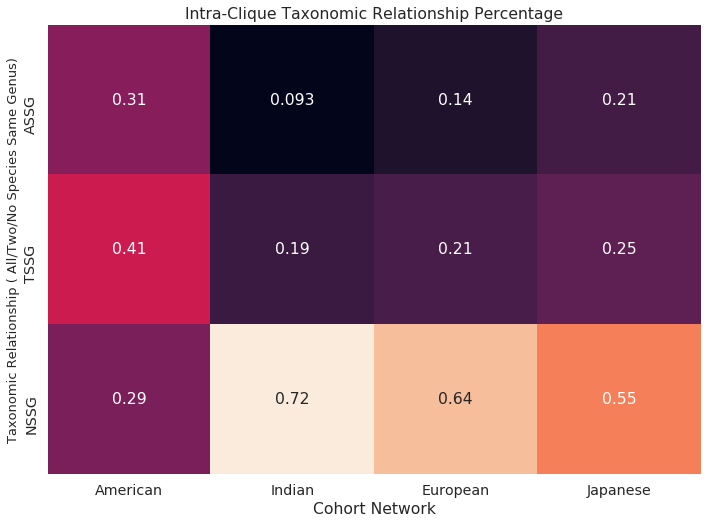

In [241]:
from collections import Counter
tempDict = {"ASSG":[], "TSSG":[], "NSSG":[], "Cohort":[]}

for cohort in allCliqueDF_3.columns:
    ASSG = 0
    TSSG = 0
    NSSG = 0
    
    for clique in allCliqueDF_3[cohort].dropna().index:
        generaList = []
        generaList.append((accTaxDictDF3.at[clique[0].replace(".","-"), 'Genus']))
        generaList.append((accTaxDictDF3.at[clique[1].replace(".","-"), 'Genus']))
        generaList.append((accTaxDictDF3.at[clique[2].replace(".","-"), 'Genus']))
        count = (Counter(generaList))
        biggestNum = 0
        for gcount in count:
            if (count[gcount]) > biggestNum:
                biggestNum = (count[gcount])
            else:
                continue
        if (biggestNum) == 3:
            ASSG +=1
        elif (biggestNum) == 2:
            TSSG +=1
        elif (biggestNum) == 1:
            NSSG +=1
        else:
            print("ERROR")
    
    tempDict['ASSG'].append(ASSG)
    tempDict['TSSG'].append(TSSG)
    tempDict['NSSG'].append(NSSG)
    tempDict['Cohort'].append(cohort)

CliqueGenusAnalysisDF = pd.DataFrame(data=tempDict).set_index("Cohort")
CliqueGenusAnalysisDF2 = CliqueGenusAnalysisDF.div(CliqueGenusAnalysisDF.sum(axis=1), axis=0).copy() 
sns.heatmap(CliqueGenusAnalysisDF2.T, annot=True, cbar=False)
plt.xlabel("Cohort Network")
plt.ylabel("Taxonomic Relationship ( All/Two/No Species Same Genus)", size=13)
plt.title("Intra-Clique Taxonomic Relationship Percentage")
plt.show()

In [180]:
allShared3Clique = allCliqueDF_3.dropna(thresh=2).copy()

In [197]:
def inspectCliques(df, numm):
    df2 = df.copy()
    
    generaList = []

    for i in list(df2.index):
        generaList.append((accTaxDictDF3.at[i[0].replace(".","-"), 'Genus']))
        generaList.append((accTaxDictDF3.at[i[1].replace(".","-"), 'Genus']))
        generaList.append((accTaxDictDF3.at[i[2].replace(".","-"), 'Genus']))
    
    generaList2 = list(set(generaList))

    tempDF = pd.DataFrame(index=generaList2, columns=['American','Indian','European','Japanese'])
    tempDF.fillna(0, inplace=True)

    for i in df2.columns:
        for x in df2[i].dropna().index:
            tempDF.at[str(accTaxDictDF3.at[x[0].replace(".","-"), 'Genus']), i] += 1
            tempDF.at[str(accTaxDictDF3.at[x[1].replace(".","-"), 'Genus']), i] += 1
            tempDF.at[str(accTaxDictDF3.at[x[2].replace(".","-"), 'Genus']), i] += 1
    
    tempDF['American'] = tempDF[['American']].div(numm*tempDF[['American']].sum())
    tempDF['Indian'] = tempDF[['Indian']].div(numm*tempDF[['Indian']].sum())
    tempDF['European'] = tempDF[['European']].div(numm*tempDF[['European']].sum())
    tempDF['Japanese'] = tempDF[['Japanese']].div(numm*tempDF[['Japanese']].sum())
    
    return (tempDF)

In [198]:
generaCliqueDf_3 = inspectCliques(allCliqueDF_3,3)
generaCliqueDf_3.head()

,American,Indian,European,Japanese
Sellimonas,0.000000,0.000000,0.000000,0.004863
Lachnoclostridium,0.002924,0.026439,0.030111,0.065470
Hungatella,0.000000,0.000000,0.000301,0.016087
Paraprevotella,0.001693,0.002677,0.000000,0.000000
Ruminococcus,0.001077,0.019076,0.012045,0.001871


In [199]:
for x in generaCliqueDf_3.index:
    generaCliqueDf_3.rename(index={x:x.replace("_"," ")}, inplace=True)

In [185]:
generaCliqueDf_3_shared = inspectCliques(allShared3Clique,3)
generaCliqueDf_3_shared.head()

,American,Indian,European,Japanese
Lachnoclostridium,0.009416,0.009662,0.023392,0.027397
Ruminococcus,0.001883,0.021739,0.017544,0.006088
Culturomica,0.003766,0.004831,0.000000,0.000000
Bifidobacterium,0.000000,0.007246,0.000000,0.004566
Fournierella,0.001883,0.000000,0.001462,0.000000


In [186]:
for x in generaCliqueDf_3_shared.index:
    generaCliqueDf_3_shared.rename(index={x:x.replace("_"," ")}, inplace=True)

In [187]:
orderList = sorted(list(generaCliqueDf_3.index))
orderList_shared = sorted(list(generaCliqueDf_3_shared.index))

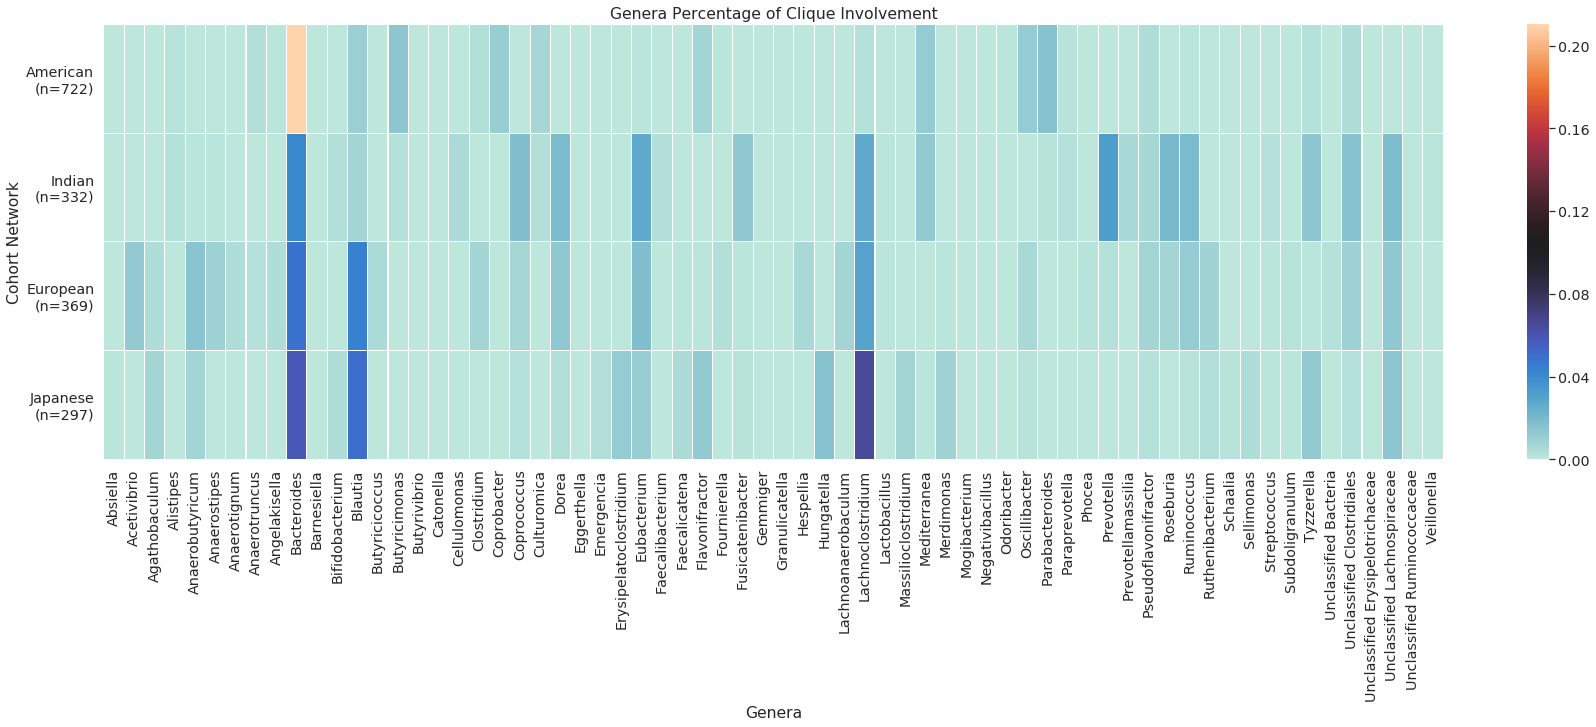

In [188]:
fig, ax = plt.subplots(figsize=(30,8))
midpoint = (generaCliqueDf_3.values.max() - generaCliqueDf_3.values.min()) / 2
ax = sns.heatmap(generaCliqueDf_3.loc[orderList].T, annot=False, xticklabels=1, yticklabels=1, linewidths=.05, ax=ax, center=midpoint)
plt.title("Genera Percentage of Clique Involvement")
plt.ylabel("Cohort Network")
plt.xlabel("Genera")

plt.yticks(rotation=0)
testList3 = []

for x in list(ax.get_yticklabels()):
    testList3.append(str(x.get_text())+"\n"+"(n="+str(len(allCliqueDF_3[x.get_text()].dropna()))+")")
    
ax.set_yticklabels(testList3)
plt.show()

/home/mark/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  This is separate from the ipykernel package so we can avoid doing imports until


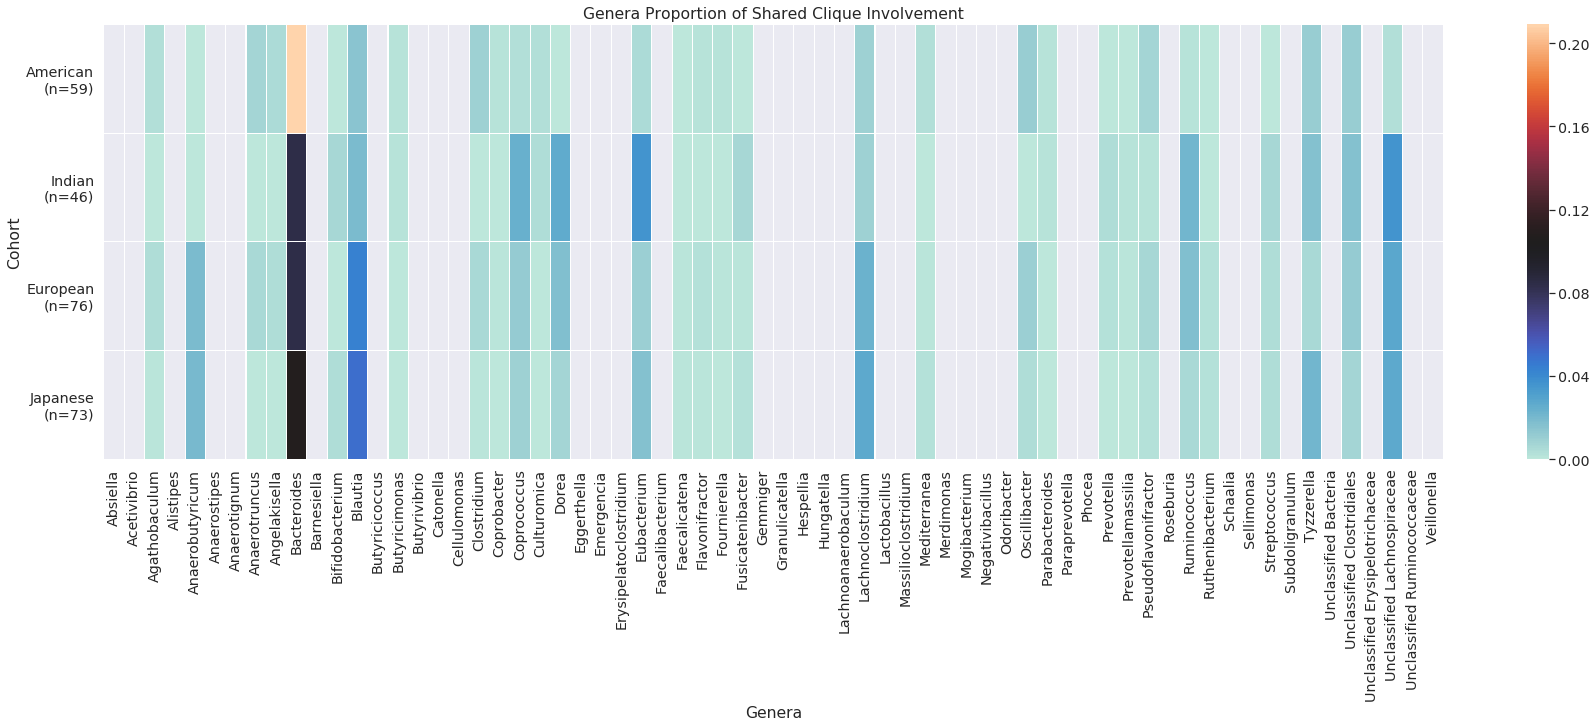

In [189]:
fig, ax = plt.subplots(figsize=(30,8))
midpoint = (generaCliqueDf_3_shared.values.max() - generaCliqueDf_3_shared.values.min()) / 2
ax = sns.heatmap(generaCliqueDf_3_shared.loc[orderList].T, annot=False, xticklabels=1, yticklabels=1, linewidths=.05, ax=ax, center=midpoint)
plt.title("Genera Proportion of Shared Clique Involvement")
plt.ylabel("Cohort")
plt.xlabel("Genera")

plt.yticks(rotation=0)
testList3 = []

for x in list(ax.get_yticklabels()):
    testList3.append(str(x.get_text())+"\n"+"(n="+str(len(allShared3Clique[x.get_text()].dropna()))+")")
    
ax.set_yticklabels(testList3)
plt.show()

## Create Network Types

In [190]:
#Erdos-Renyi Random Networks
from tqdm import tqdm
import numpy as np
from networkx.algorithms.community.label_propagation import asyn_lpa_communities
from networkx.algorithms.community.quality import modularity
from networkx.generators.random_graphs import erdos_renyi_graph

def createRandom(network):
    
    columnNames = {"ASPL":[],"Average_Degree":[], "Modularity":[], "Average_Clustering_Coefficient":[],"Abundance_Assortativity":[],"Genera_Assortativity":[], "Degree_Assortativity":[],"Transitivity":[]}
        
    n = len(network.nodes)
    p = nx.density(network)
    
    generaList = []
    for x in list(network.nodes(data='genera')):
        generaList.append(x[1])
        
    abundanceList = []
    for y in list(network.nodes(data='relativeAbundance')):
        abundanceList.append(y[1])
        
    
    seedNum = 101
    for i in tqdm(range(1000)):
        
        G = nx.erdos_renyi_graph(n, p, seed=seedNum)
        
        randomPartitions = list(asyn_lpa_communities(G))
        columnNames['Modularity'].append(modularity(G, randomPartitions))
              
        generaList2 = generaList
        shuffle(generaList2)
        
        abundanceList2 = abundanceList
        shuffle(abundanceList2)
        
        j = 0
        for node in G.nodes:
            G.nodes[node]['relativeAbundance'] = abundanceList2[j]
            G.nodes[node]['genera'] = generaList2[j]
            j+=1
        
        if nx.is_connected(G):
            degreeList = [d for v, d in G.degree()]
            columnNames['Average_Degree'].append(np.mean(degreeList))
            
            columnNames['ASPL'].append(nx.average_shortest_path_length(G))
            columnNames['Average_Clustering_Coefficient'].append(nx.average_clustering(G))
            columnNames['Degree_Assortativity'].append(nx.degree_assortativity_coefficient(G))
            columnNames['Transitivity'].append(nx.transitivity(G))
            columnNames['Abundance_Assortativity'].append(nx.attribute_assortativity_coefficient(G, 'relativeAbundance'))
            columnNames['Genera_Assortativity'].append(nx.attribute_assortativity_coefficient(G, 'genera'))
        else:
            #IF the network is not connected then take the largest connected component and run stats.
            Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
            L2 = []
            for sub in Gcc:
                if len(sub) > 1:
                    sub0 = G.subgraph(sub)
                    L2.append(nx.average_shortest_path_length(sub0))
                else:
                    continue
                    
                    
            degreeList = [d for v, d in G.degree()]
            columnNames['Average_Degree'].append(np.mean(degreeList))
    
            columnNames['ASPL'].append(np.mean(L2))
            columnNames['Average_Clustering_Coefficient'].append(nx.average_clustering(G))
            columnNames['Degree_Assortativity'].append(nx.degree_assortativity_coefficient(G))
            columnNames['Transitivity'].append(nx.transitivity(G))
            columnNames['Abundance_Assortativity'].append(nx.attribute_assortativity_coefficient(G, 'relativeAbundance'))
            columnNames['Genera_Assortativity'].append(nx.attribute_assortativity_coefficient(G, 'genera'))
        ####################################################################################   
        seedNum+=1
        
    dataF = pd.DataFrame(data=columnNames)
    return(dataF)

## Build chosen models

In [191]:
#Rdf_american = createRandom(americanNetwork)
#Rdf_indian = createRandom(indianNetwork)
#Rdf_european = createRandom(europeanNetwork)
#Rdf_japanese = createRandom(japaneseNetwork)